# Results Analysis

In [2]:
import numpy as np
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import warnings
import pickle

## Load Original Series and Manoeuvres

In [4]:
orbital_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\all_satellite_orbitals.csv"
maneuver_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\cleaned_maneuvers.csv"
df_orbital = pd.read_csv(orbital_file)
df_maneuver = pd.read_csv(maneuver_file)

In [6]:
#Filter the dataset with the satellites selected for the report
df_orbital_filtered = df_orbital[
    df_orbital['satellite_name'].isin(["Fengyun_2E", "Fengyun_2F","Fengyun_4A", "Jason_3", "Sentinel_3A","Sentinel_3B","CryoSat_2"])]

# Plots

In [8]:

def plot_orbital_data(df_orbital, satellite=None, variable='Brouwer mean motion',
                      start_date=None, end_date=None, 
                      ground_truth_dict=None, save_path=None):
    """
    Plot orbital data (e.g., Brouwer Mean Motion) over time with optional maneuver timestamps.
    
    Parameters:
    - df_orbital: DataFrame with orbital data (must have 'epoch', variable column, 'satellite_name')
    - satellite: Satellite name to plot (e.g., 'CryoSat_2'). If None, plots all satellites
    - variable: Column name to plot (e.g., 'Brouwer mean motion')
    - start_date, end_date: Date filtering (strings or datetime objects)
    - ground_truth_dict: Optional dictionary with maneuver timestamps
    - save_path: Optional path to save the figure
    """
    
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Color scheme consistent with other plots
    plot_colors = {
        'data': "#000000",          # Black for orbital data
        'maneuvers': "#D55E00",     # Vermillion for maneuvers
    }
    
    # Prepare data
    df_plot = df_orbital.copy()
    
    # Convert epoch to datetime
    df_plot['epoch'] = pd.to_datetime(df_plot['epoch'])
    
    # Filter by satellite if specified
    if satellite is not None:
        df_plot = df_plot[df_plot['satellite_name'] == satellite]
        if df_plot.empty:
            available_satellites = df_orbital['satellite_name'].unique()
            print(f"No data found for satellite '{satellite}'")
            print(f"Available satellites: {available_satellites}")
            return
    
    # Apply date filtering
    if start_date:
        df_plot = df_plot[df_plot['epoch'] >= pd.to_datetime(start_date)]
    if end_date:
        df_plot = df_plot[df_plot['epoch'] <= pd.to_datetime(end_date)]
    
    if df_plot.empty:
        print("No data remaining after filtering")
        return
    
    # Check if variable exists
    if variable not in df_plot.columns:
        available_vars = [col for col in df_plot.columns if col not in ['epoch', 'satellite_name', 'epoch_date']]
        print(f"Variable '{variable}' not found in DataFrame")
        print(f"Available variables: {available_vars}")
        return
    
    # Create plot
    plt.figure(figsize=(14, 6))
    
    if satellite is None:
        # Plot multiple satellites with different colors
        satellites = df_plot['satellite_name'].unique()
        satellite_colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", 
                           "#F0E442", "#0072B2", "#CC79A7"]  # Okabe-Ito colors
        
        for idx, sat in enumerate(satellites):
            sat_data = df_plot[df_plot['satellite_name'] == sat]
            color = satellite_colors[idx % len(satellite_colors)]
            plt.plot(sat_data['epoch'], sat_data[variable], 
                    label=sat, color=color, linewidth=2, alpha=0.8)
        
        title_prefix = "All Satellites"
    else:
        # Single satellite plot
        plt.plot(df_plot['epoch'], df_plot[variable], 
                label=satellite, color=plot_colors['data'], linewidth=2)
        title_prefix = satellite
    
    # Add maneuver timestamps if provided
    if ground_truth_dict is not None:
        satellites_to_check = [satellite] if satellite else df_plot['satellite_name'].unique()
        
        for sat in satellites_to_check:
            maneuver_timestamps = []
            
            # Try different ground truth formats
            if isinstance(ground_truth_dict, pd.DataFrame):
                df_maneuver_sat = ground_truth_dict[ground_truth_dict['OrbitalKeyName'] == sat]
                if 'start_date' in df_maneuver_sat.columns:
                    maneuver_timestamps = pd.to_datetime(df_maneuver_sat['start_date'], errors='coerce').dropna()
            
            elif isinstance(ground_truth_dict, dict):
                # Try satellite key
                if sat in ground_truth_dict:
                    maneuver_timestamps = ground_truth_dict[sat]
                # Try (satellite, variable) tuple key
                else:
                    tuple_key = (sat, variable)
                    if tuple_key in ground_truth_dict:
                        maneuver_timestamps = ground_truth_dict[tuple_key]
            
            # Filter maneuvers to date range and plot
            if len(maneuver_timestamps) > 0:
                maneuver_timestamps = pd.to_datetime(maneuver_timestamps)
                if start_date:
                    maneuver_timestamps = maneuver_timestamps[maneuver_timestamps >= pd.to_datetime(start_date)]
                if end_date:
                    maneuver_timestamps = maneuver_timestamps[maneuver_timestamps <= pd.to_datetime(end_date)]
                
                # Plot maneuver lines
                for i, timestamp in enumerate(maneuver_timestamps):
                    if i == 0 and sat == satellites_to_check[0]:  # Add label only once
                        plt.axvline(x=timestamp, color=plot_colors['maneuvers'], 
                                  linestyle='--', alpha=0.7, linewidth=1, label='Maneuvers')
                    else:
                        plt.axvline(x=timestamp, color=plot_colors['maneuvers'], 
                                  linestyle='--', alpha=0.7, linewidth=1)
    
    # Formatting
    date_range = ""
    if start_date or end_date:
        date_range = f"\nDate range: {start_date or 'start'} to {end_date or 'end'}"
    
    plt.title(f"{title_prefix} - {variable}{date_range}")
    plt.xlabel("Date")
    plt.ylabel(variable)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [10]:
def scenario_label(scn: str) -> str:
    """Map stored scenario strings/ids to concise, reader-friendly labels."""
    s = str(scn).strip()
    mapping = {
        "Scenario 1": "Base Model",
        "Scenario 2": "Forced Diff",
        "Scenario 3 (MAD σ=10)": "MAD σ=10",
        "Scenario 3 (MAD σ=20)": "MAD σ=20",
        "Scenario 4": "Log Transform",
        "Scenario 5 (win=7)": "Smooth w=7",
        "Scenario 5 (win=9)": "Smooth w=9",
        # optional fallbacks if your data ever uses shorter forms:
        "Scenario 3": "MAD σ=10",
        "Scenario 5": "Smooth",
        "1": "Base Model", "2": "Forced Diff", "4": "Log Transform",
        "5 (win=7)": "Smooth w=7", "5 (win=9)": "Smooth w=9",
    }
    return mapping.get(s, s)

In [12]:
def plot_residuals_with_maneuvers(
    results, maneuvers_dict,
    satellite, variable, scenarios,
    algorithm='arima',                 # 'arima' or 'xgboost'
    start_date=None, end_date=None,
    plot_absolute=True,               # True: |residuals|, False: raw
    save_as=None,
    lw_residual=2.0,
    lw_manoeuvres=2.0
):
    # Okabe–Ito palette
    okabe_ito = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#2E7BA6","#D55E00","#CC79A7"]
    col_manoeuvres = okabe_ito[6]         # vermilion
    first_residual_color = "#0072B2"      # darker blue

    # Build colour cycle for scenarios (exclude index 6 which is manoeuvres)
    residual_palette = [okabe_ito[i] for i in [0,1,2,3,4,5,7]]

    start_ts = pd.to_datetime(start_date) if start_date else None
    end_ts   = pd.to_datetime(end_date) if end_date else None

    # Collect the data for each scenario (assume exact keys & names)
    scenario_series = []
    for sc in scenarios:
        r = next((x for x in results
                  if x['satellite'] == satellite and
                     x['variable']  == variable  and
                     x['scenario']  == sc), None)
        if r is None:
            continue

        if algorithm.lower() == 'xgboost':
            df = r['result_df'].copy()
            df['epoch'] = pd.to_datetime(df['epoch'])
            s = pd.Series(df['residuals'].values, index=df['epoch'])
        else:  # arima
            res = r['residuals']() if callable(r['residuals']) else r['residuals']
            # ensure Series with DateTimeIndex
            if not isinstance(res, pd.Series):
                res = pd.Series(res)
            if not isinstance(res.index, pd.DatetimeIndex):
                res.index = pd.to_datetime(res.index)
            s = res

        # Date filter
        if start_ts is not None: s = s[s.index >= start_ts]
        if end_ts   is not None: s = s[s.index <= end_ts]

        scenario_series.append((sc, s))

    # Nothing to plot?
    if not scenario_series:
        print("No matching residual series found.")
        return

    # Start plot
    plt.figure(figsize=(14,6))

    # Plot each scenario
    for idx, (sc, s) in enumerate(scenario_series):
        y = s.abs() if plot_absolute else s
        color = first_residual_color if idx == 0 else residual_palette[(idx-1) % len(residual_palette)]
        plt.plot(
            s.index, y.values,
            label=scenario_label(sc),       # CHANGED: use friendly label
            lw=lw_residual, alpha=0.9, color=color
        )

    # Zero line for raw residuals
    if not plot_absolute:
        plt.axhline(0, color="#666666", lw=1.2, alpha=0.5)

    # Manoeuvre verticals (ARIMA-style dict)
    man_times = pd.to_datetime(maneuvers_dict.get(satellite, []))
    if start_ts is not None: man_times = man_times[man_times >= start_ts]
    if end_ts   is not None: man_times = man_times[man_times <= end_ts]
    for i, t in enumerate(man_times):
        plt.axvline(t, color=col_manoeuvres, linestyle='--',
                    lw=lw_manoeuvres, alpha=0.9,
                    label='Manoeuvres' if i == 0 else "")

    # Labels & layout
    ylabel = "Absolute Residuals" if plot_absolute else "Residuals (Original - Predicted)"
    plt.title(f"{satellite} — {variable}")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.1)
    plt.tight_layout()

    if save_as:
        if not save_as.lower().endswith(".png"):
            save_as += ".png"
        plt.savefig(save_as, dpi=300, bbox_inches='tight')

    plt.show()

In [14]:
def plot_predictions_standard(
    algorithm, results, maneuvers_dict,
    satellite, variable, scenario,
    start_date=None, end_date=None,
    save_as=None,
    lw_series=2, lw_pred=2, lw_manoeuvres=2
):
    # Okabe–Ito colours
    okabe_ito = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]
    col_input_or_original = okabe_ito[0]
    col_predicted          = okabe_ito[1]
    col_manoeuvres         = okabe_ito[6]

    start_ts = pd.to_datetime(start_date) if start_date else None
    end_ts   = pd.to_datetime(end_date) if end_date else None

    # Find matching result
    r = next((x for x in results if x['satellite'] == satellite
              and x['variable'] == variable
              and x['scenario'] == scenario), None)
    if r is None:
        print("No match found for your satellite/variable/scenario.")
        return

    plt.figure(figsize=(14,6))

    if algorithm.lower() == 'xgb':
        df = r['result_df'].copy()
        df['epoch'] = pd.to_datetime(df['epoch'])
        if start_ts is not None: df = df[df['epoch'] >= start_ts]
        if end_ts is not None:   df = df[df['epoch'] <= end_ts]

        plt.plot(df['epoch'], df['original'], label='Input series', color=col_input_or_original, lw=lw_series)
        plt.plot(df['epoch'], df['predicted'], label='Predicted (XGB)', color=col_predicted, lw=lw_pred)

    elif algorithm.lower() == 'arima':
        fitted = r['fitted_values']() if callable(r['fitted_values']) else r['fitted_values']
        series = r['input_series']() if callable(r['input_series']) else r['input_series']

        common_index = fitted.index.intersection(series.index).sort_values()
        if start_ts is not None: common_index = common_index[common_index >= start_ts]
        if end_ts is not None:   common_index = common_index[common_index <= end_ts]

        plt.plot(common_index, series.loc[common_index], label='Input series', color=col_input_or_original, lw=lw_series)
        plt.plot(common_index, fitted.loc[common_index], label='Predicted (ARIMA)', color=col_predicted, lw=lw_pred)

    # Manoeuvre lines
    man_times = pd.to_datetime(maneuvers_dict.get(satellite, []))
    if start_ts is not None: man_times = man_times[man_times >= start_ts]
    if end_ts is not None:   man_times = man_times[man_times <= end_ts]
    for i, t in enumerate(man_times):
        plt.axvline(x=t, color=col_manoeuvres, linestyle='--', lw=lw_manoeuvres, alpha=0.8,
                    label='Manoeuvres' if i == 0 else "")

    plt.title(f"{satellite} — {variable} — {scenario}")
    plt.ylabel(f"{variable} (with pre-processing)")
    plt.legend()
    plt.grid(True, alpha=0.1)
    plt.tight_layout()

    if save_as:
        if not save_as.lower().endswith(".png"):
            save_as += ".png"
        plt.savefig(save_as, dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
def plot_predictions_scenario5(
    results, maneuvers_dict,
    satellite, variable, scenario,
    start_date=None, end_date=None,
    save_as=None,
    lw_series=2, lw_pred=2, lw_manoeuvres=2
):
    okabe_ito = ["#000000","#E69F00","#A6A6A6","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]
    col_input_or_original = okabe_ito[0]  # after smoothing
    col_predicted          = okabe_ito[1]
    col_manoeuvres         = okabe_ito[6]
    col_series_original    = okabe_ito[2]  # before smoothing

    start_ts = pd.to_datetime(start_date) if start_date else None
    end_ts   = pd.to_datetime(end_date) if end_date else None

    r = next((x for x in results if x['satellite'] == satellite
              and x['variable'] == variable
              and x['scenario'] == scenario), None)
    if r is None:
        print("No match found for your satellite/variable/scenario.")
        return

    plt.figure(figsize=(14,6))

    fitted = r['fitted_values']() if callable(r['fitted_values']) else r['fitted_values']
    series_orig = r['series_original']() if callable(r['series_original']) else r['series_original']
    series_input = r['input_series']() if callable(r['input_series']) else r['input_series']

    common_index = fitted.index.intersection(series_orig.index).intersection(series_input.index).sort_values()
    if start_ts is not None: common_index = common_index[common_index >= start_ts]
    if end_ts is not None:   common_index = common_index[common_index <= end_ts]

    plt.plot(common_index, series_orig.loc[common_index], label='Before smoothing', color=col_series_original, lw=lw_series)
    plt.plot(common_index, series_input.loc[common_index], label='After smoothing', color=col_input_or_original, lw=lw_series)
    plt.plot(common_index, fitted.loc[common_index], label='Predicted (ARIMA)', color=col_predicted, lw=lw_pred)

    man_times = pd.to_datetime(maneuvers_dict.get(satellite, []))
    if start_ts is not None: man_times = man_times[man_times >= start_ts]
    if end_ts is not None:   man_times = man_times[man_times <= end_ts]
    for i, t in enumerate(man_times):
        plt.axvline(x=t, color=col_manoeuvres, linestyle='--', lw=lw_manoeuvres, alpha=0.8,
                    label='Manoeuvres' if i == 0 else "")

    plt.title(f"{satellite} — {variable} — {scenario}")
    plt.ylabel(f"{variable} (with pre-processing)")
    plt.legend()
    plt.grid(True, alpha=0.1)
    plt.tight_layout()

    if save_as:
        if not save_as.lower().endswith(".png"):
            save_as += ".png"
        plt.savefig(save_as, dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
def plot_precision_recall_algorithm_comparison(
    pr_data_arima,
    pr_data_xgboost,
    satellite,
    variable,
    matching_days=3,
    figsize=(16, 7)
):
    """
    Plot precision-recall curves comparing ARIMA vs XGBoost algorithms
    Left plot: ARIMA, Right plot: XGBoost, both with the same matching window.
    """
    import matplotlib.pyplot as plt

    # Define scenario strings for both algorithms (assuming they're the same)
    scenarios = [
        "Scenario 1",            
        "Scenario 2",            
        "Scenario 3 (MAD σ=10)",  
        "Scenario 3 (MAD σ=20)", 
        "Scenario 4",                     
        "Scenario 5 (win=7)",    
        "Scenario 5 (win=9)"     
    ]
    
    # Improved, concise scenario descriptions
    scenario_labels = [
        "Base Model",           # Scenario 1
        "Forced Diff",          # Scenario 2
        "MAD σ=10",            # Scenario 3: MAD σ=10
        "MAD σ=20",            # Scenario 3: MAD σ=20
        "Log Transform",        # Scenario 4
        "Smooth w=7",          # Scenario 5: w=7
        "Smooth w=9"           # Scenario 5: w=9
    ]
    
    # Colorblind-friendly color palette
    colors = [
        '#0d0d0d',  # Deep blue (Base Model)
        '#ff7f0e',  # Orange (Forced Diff)
        '#ed1c24',  # Red (MAD σ=10)
        '#ffa1a8',  # Light red (MAD σ=20)
        '#a2efe7',  # Cyan (Log Transform) 
        '#4b51e9',  # Blue (Smooth w=7)
        '#929af4'   # Light blue (Smooth w=9)
    ]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    
    # Algorithm data and titles
    algorithms = [
        {"data": pr_data_arima, "title": "ARIMA", "ax_idx": 0},
        {"data": pr_data_xgboost, "title": "XGBoost", "ax_idx": 1}
    ]

    legend_lines = []
    legend_labels = []

    for alg_info in algorithms:
        ax_idx = alg_info["ax_idx"]
        ax = axes[ax_idx]
        pr_data = alg_info["data"]
        alg_title = alg_info["title"]
        
        ax.set_title(f"{alg_title}", fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel("Recall", fontsize=12, fontweight='bold')
        if ax_idx == 0:
            ax.set_ylabel("Precision", fontsize=12, fontweight='bold')

        # Reference lines
        ax.axhline(0.5, color='lightgrey', linestyle='--', linewidth=1, alpha=0.7)
        ax.axvline(0.5, color='lightgrey', linestyle='--', linewidth=1, alpha=0.7)
        ax.fill_between([0.5, 1.0], 0.5, 1.0, color='lightblue', alpha=0.15)

        for scenario, scenario_label, color in zip(scenarios, scenario_labels, colors):
            found_match = False
            for entry in pr_data:
                if (
                    entry["satellite"] == satellite and
                    entry["variable"] == variable and
                    entry["scenario"] == scenario and
                    entry["matching_max_days"] == matching_days
                ):
                    found_match = True
                    # Different line styles for scenario variations
                    scenario_str = str(scenario)
                    if "MAD σ=20" in scenario_str or "win=9" in scenario_str:
                        linestyle = '--'  # Dashed for variations
                        alpha = 0.8
                    else:
                        linestyle = '-'   # Solid for main scenarios
                        alpha = 0.9
                    
                    line = ax.plot(
                        entry["recall"],
                        entry["precision"],
                        label=scenario_label,
                        linewidth=2,
                        color=color,
                        linestyle=linestyle,
                        alpha=alpha
                    )[0]

                    # Only add to legend once (from the first algorithm)
                    if ax_idx == 0:
                        legend_lines.append(line)
                        legend_labels.append(scenario_label)
                    break
            
            if not found_match:
                print(f"Warning: No data found for {alg_title} - {satellite} - {variable} - {scenario} - {matching_days} days")
            
        ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.tick_params(labelsize=10)

    # Enhanced legend
    legend = fig.legend(
        legend_lines,
        legend_labels,
        title="Preprocessing Scenarios",
        title_fontsize=12,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.96),
        ncol=min(4, len(scenarios)),
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=10,
        columnspacing=1.8,
        handletextpad=0.8
    )
    legend.get_title().set_fontweight('bold')

    fig.suptitle(
        f"Algorithm Comparison: {satellite} – {variable} (Matching Window: {matching_days} Days)",
        fontsize=16,
        fontweight='bold',
        y=0.99
    )

    plt.tight_layout(rect=[0, 0.02, 1, 0.89])
    plt.show()

In [20]:
def plot_precision_recall_comparison_by_scenario(
    pr_data_arima,
    satellite,
    variable,
    match_days_pair=(2, 3),
    figsize=(16, 7)
):
    """
    Plot precision-recall curves for ARIMA scenarios with colorblind-friendly colors
    and improved scenario descriptions.
    """
    import matplotlib.pyplot as plt

    # Define ARIMA scenario strings exactly as stored in results
    # Handle both string and integer scenario formats
    scenarios = [
        "Scenario 1",            
        "Scenario 2",            
        "Scenario 3 (MAD σ=10)",  
        "Scenario 3 (MAD σ=20)", 
        "Scenario 4",                     
        "Scenario 5 (win=7)",    
        "Scenario 5 (win=9)"     
    ]
    
    # Improved, concise scenario descriptions
    scenario_labels = [
        "Base Model",           # Scenario 1: Standard preprocessing, stationarity-based differencing
        "Forced Diff",          # Scenario 2: Always applies differencing  
        "MAD σ=10",            # Scenario 3: Outlier removal with 10-sigma threshold
        "MAD σ=20",            # Scenario 3: Outlier removal with 20-sigma threshold
        "Log Transform",        # Scenario 4: Log transformation
        "Smooth w=7",          # Scenario 5: Savitzky-Golay smoothing, window=7
        "Smooth w=9"           # Scenario 5: Savitzky-Golay smoothing, window=9
    ]
    
    # Truly colorblind-friendly, professional color palette
    # Avoids red-green combinations entirely and uses high-contrast colors
    colors = [
        '#0d0d0d',  # Deep blue (Base Model)
        '#ff7f0e',  # Orange (Forced Diff) - blue/orange is colorblind-safe
        '#ed1c24',  # Purple (MAD σ=10)
        '#ffa1a8',  # Light purple (MAD σ=20) - related to MAD σ=10 but distinguishable
        '#a2efe7',  # Brown (Log Transform) 
        '#4b51e9',  # Cyan (Smooth w=7)
        '#929af4'   # Light cyan (Smooth w=9) - related to w=7 but distinguishable
    ]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    legend_lines = []
    legend_labels = []

    for ax_idx, match_days in enumerate(match_days_pair):
        ax = axes[ax_idx]
        ax.set_title(f"Matching Window: {match_days} Days", fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel("Recall", fontsize=12, fontweight='bold')
        if ax_idx == 0:
            ax.set_ylabel("Precision", fontsize=12, fontweight='bold')

        # Reference lines
        ax.axhline(0.5, color='lightgrey', linestyle='--', linewidth=1, alpha=0.7)
        ax.axvline(0.5, color='lightgrey', linestyle='--', linewidth=1, alpha=0.7)
        ax.fill_between([0.5, 1.0], 0.5, 1.0, color='lightblue', alpha=0.15)

        for scenario, scenario_label, color in zip(scenarios, scenario_labels, colors):
            found_match = False
            for entry in pr_data_arima:
                if (
                    entry["satellite"] == satellite and
                    entry["variable"] == variable and
                    entry["scenario"] == scenario and
                    entry["matching_max_days"] == match_days
                ):
                    found_match = True
                    # Different line styles for scenario variations to enhance distinction
                    scenario_str = str(scenario)
                    if "MAD σ=20" in scenario_str or "win=9" in scenario_str:
                        linestyle = '--'  # Dashed for the "second" variation
                        alpha = 0.8
                    else:
                        linestyle = '-'   # Solid for main scenarios and first variations
                        alpha = 0.9
                    
                    line = ax.plot(
                        entry["recall"],
                        entry["precision"],
                        label=scenario_label,
                        linewidth=2,
                        color=color,
                        linestyle=linestyle,
                        alpha=alpha
                        #marker='o',
                        #markersize=3,
                        #markevery=5
                    )[0]

                    if ax_idx == 0:
                        legend_lines.append(line)
                        legend_labels.append(scenario_label)
                    break
            
            
        ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.tick_params(labelsize=10)

    # Enhanced legend with better positioning
    legend = fig.legend(
        legend_lines,
        legend_labels,
        title="XGBoost Preprocessing Scenarios",
        title_fontsize=12,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.96),
        ncol=min(4, len(scenarios)),  # Adaptive column count
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=10,
        columnspacing=1.8,
        handletextpad=0.8
    )
    legend.get_title().set_fontweight('bold')

    fig.suptitle(
        f"XGBoost Precision-Recall Curves: {satellite} – {variable}",
        fontsize=16,
        fontweight='bold',
        y=0.99
    )

    plt.tight_layout(rect=[0, 0.02, 1, 0.89])
    plt.show()

In [22]:
def plot_precision_recall_comparison_by_window(
    pr_data_arima,
    satellite,
    variable,
    match_days_pair=(2, 3),
    figsize=(16, 7),
    algorithm_name="ARIMA",
    save_path=None
):
    """
    Compare one satellite across two matching windows (e.g., 3 vs 4 days).
    Style matches plot_precision_recall_multiple_satellitesv2.
    Saves to PNG if save_path is provided; otherwise just shows.
    """
    import matplotlib.pyplot as plt

    # --- Scenarios & labels (unchanged logic) ---
    scenarios = [
        "Scenario 1",               # Base
        "Scenario 2",               # Forced diff
        "Scenario 3 (MAD σ=10)",    # MAD 10
        "Scenario 3 (MAD σ=20)",    # MAD 20
        "Scenario 4",               # Log
        "Scenario 5 (win=7)",       # Smooth w=7
        "Scenario 5 (win=9)"        # Smooth w=9
    ]
    scenario_labels = [
        "Base Model",
        "Forced Diff",
        "MAD σ=10",
        "MAD σ=20",
        "Log Transform",
        "Smooth w=7",
        "Smooth w=9",
    ]

    # --- Final palette you chose ---
    okabe_ito = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]
    colors = [
        okabe_ito[0],   # Base: black
        okabe_ito[1],   # Forced Diff: orange
        "#F3A27B",      # MAD 10: peach
        okabe_ito[6],   # MAD 20: vermillion
        okabe_ito[3],   # Log: green
        okabe_ito[2],   # Smooth w=7: sky blue (solid)
        "#2E7BA6",      # Smooth w=9: darker blue (dashed)
    ]

    # --- Figure / axes ---
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    drawn_for_legend = []
    drawn_labels = []

    for ax_idx, match_days in enumerate(match_days_pair):
        ax = axes[ax_idx]
        ax.set_title(f"Matching Window: {match_days} days", fontsize=14, fontweight='bold', pad=14)

        # Axis labels
        ax.set_xlabel("Recall", fontsize=12, fontweight='bold')
        if ax_idx == 0:
            ax.set_ylabel("Precision", fontsize=12, fontweight='bold')

        # Background / guides (same vibe as v2)
        ax.axhline(0.5, color='#b3b3b3', linestyle='--', linewidth=0.9, alpha=0.7)
        ax.axvline(0.5, color='#b3b3b3', linestyle='--', linewidth=0.9, alpha=0.7)
        ax.fill_between([0.5, 1.0], 0.5, 1.0, color='#cfe8ff', alpha=0.18)

        # Plot each scenario
        for scenario, label, color in zip(scenarios, scenario_labels, colors):
            for entry in pr_data_arima:
                if (
                    entry["satellite"] == satellite and
                    entry["variable"] == variable and
                    entry["scenario"] == scenario and
                    entry["matching_max_days"] == match_days
                ):
                    # dashed for the "second" variants (MAD20, win=9)
                    scen_str = str(scenario)
                    linestyle = '--' if ("MAD σ=20" in scen_str or "win=9" in scen_str) else '-'
                    alpha = 0.95 if linestyle == '-' else 0.9

                    line, = ax.plot(
                        entry["recall"],
                        entry["precision"],
                        color=color,
                        linewidth=2.2,
                        linestyle=linestyle,
                        alpha=alpha,
                        label=label
                    )

                    # only collect once for legend
                    if ax_idx == 0:
                        drawn_for_legend.append(line)
                        drawn_labels.append(label)
                    break

        # Ticks, limits, grid
        ax.grid(True, linestyle='--', alpha=0.32, linewidth=0.6)
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(0.0, 1.03)  # <- headroom so precision=1 lines are visible
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.tick_params(labelsize=10)

    # --- Legend ABOVE the panel titles (no overlap) ---
    fig.legend(
        drawn_for_legend,
        drawn_labels,
        title=f"{algorithm_name} Preprocessing Scenarios",
        title_fontsize=12,
        fontsize=12,
        ncol=4,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.995),  # high above the axes
        frameon=True,
        fancybox=True,
        shadow=False,
        columnspacing=1.6,
        handletextpad=0.8
    )

    # Title + layout
    fig.suptitle(
        f"{algorithm_name} PR by Matching Window: {satellite} – {variable}",
        fontsize=16, fontweight='bold', y=1.06
    )
    # Leave space for both suptitle and legend
    fig.tight_layout(rect=[0, 0.03, 1, 0.90])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

In [24]:
def plot_precision_recall_multiple_satellites_v2(
    pr_data,
    satellites,
    variable,
    algorithm_name="ARIMA",
    matching_days=3,
    figsize=None,
    use_panel_titles=True,
    shade_operating_region=True,
    save_path=None  
):
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    from matplotlib.axes import Axes

    # Publication defaults
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["axes.edgecolor"] = "#333333"
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10

    n_satellites = len(satellites)
    if n_satellites < 2:
        raise ValueError("Need at least 2 satellites for comparison")
    if n_satellites > 6:
        print("Warning: More than 6 satellites may result in crowded plots")

    n_cols = min(2, n_satellites)
    n_rows = math.ceil(n_satellites / n_cols)

    if figsize is None:
        figsize = (8.5 * n_cols, 6.2 * n_rows)

    # Scenarios
    scenarios = [
        "Scenario 1",
        "Scenario 2",
        "Scenario 3 (MAD σ=10)",
        "Scenario 3 (MAD σ=20)",
        "Scenario 4",
        "Scenario 5 (win=7)",
        "Scenario 5 (win=9)",
    ]
    scenario_labels = [
        "Base Model",
        "Forced Diff",
        "MAD σ=10",
        "MAD σ=20",
        "Log Transform",
        "Smooth w=7",
        "Smooth w=9",
    ]

    # Okabe–Ito palette + high-contrast purple for Log Transform
    okabe_ito = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]
    
    colors = [
        okabe_ito[0],  # Base Model: black
        okabe_ito[1],  # Forced Diff: orange  
        "#F3A27B",  # MAD σ=10
        okabe_ito[6],     # MAD σ=20 (lighter vermillion)
        okabe_ito[3],  # Log Transform: reddish purple
        okabe_ito[2],     # Smooth w=7: sky blue (#56B4E9) - solid
        "#2E7BA6",        # Smooth w=9: darker sky blue - dashed
    ]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=True)

    # Flatten axes list safely
    if isinstance(axes, Axes):
        axes_list = [axes]
    else:
        axes_list = np.array(axes, dtype=object).ravel().tolist()

    legend_handles, legend_texts = [], []

    for idx, satellite in enumerate(satellites):
        ax = axes_list[idx]

        if use_panel_titles:
            ax.set_title(satellite, fontsize=13, fontweight="bold", pad=10)

        ax.set_xlabel("Recall")
        if idx % n_cols == 0:
            ax.set_ylabel("Precision")

        ax.axhline(0.5, color="#BBBBBB", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.axvline(0.5, color="#BBBBBB", linestyle="--", linewidth=0.8, alpha=0.7)
        if shade_operating_region:
            ax.fill_between([0.5, 1.0], 0.5, 1.0, color="#C7E9FF", alpha=0.12, zorder=0)

        for scenario, label, color in zip(scenarios, scenario_labels, colors):
            for entry in pr_data:
                if (
                    entry["satellite"] == satellite
                    and entry["variable"] == variable
                    and entry["scenario"] == scenario
                    and entry["matching_max_days"] == matching_days
                ):
                    dashed = ("MAD σ=20" in scenario) or ("win=9" in scenario)
                    line = ax.plot(
                        entry["recall"],
                        entry["precision"],
                        color=color,
                        linewidth=2.2,
                        linestyle="--" if dashed else "-",
                        alpha=0.95 if not dashed else 0.9,
                        label=label if idx == 0 else None,
                    )[0]
                    if idx == 0:
                        legend_handles.append(line)
                        legend_texts.append(label)
                    break

        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.25)
        ax.set_xlim(0.0, 1.02)
        ax.set_ylim(-0.02, 1.02)  # <--- extra top padding
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    for ax in axes_list[n_satellites:]:
        ax.set_visible(False)

    fig.suptitle(
        f"{algorithm_name} Multi-Satellite PR: {variable}  (Matching Window: {matching_days} days)",
        fontsize=15,
        fontweight="bold",
        y=0.98,
    )

    legend = fig.legend(
        legend_handles,
        legend_texts,
        title=f"{algorithm_name} Preprocessing Scenarios",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.93),
        ncol=min(4, len(scenarios)),
        frameon=True,
        fancybox=False,
        shadow=False,
        fontsize=10,
        borderpad=0.6,
        columnspacing=1.6,
        handletextpad=0.6,
    )
    legend.get_title().set_fontsize(11)
    legend.get_title().set_fontweight("bold")

    plt.tight_layout(rect=[0.03, 0.04, 1, 0.90])

    # Save if path is provided
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [77]:
def plot_xgboost_run_comparison(
    pr_data_run1,
    pr_data_run2,
    satellites,  # List of exactly 2 satellites
    variable,
    run1_label="Run 1",
    run2_label="Run 2",
    matching_days=3,
    figsize=None,
    shade_operating_region=True,
    save_path=None  
):
    """
    Compare two XGBoost runs for two satellites in a 2x2 layout.
    
    Parameters:
    - pr_data_run1: PR data from first XGBoost run
    - pr_data_run2: PR data from second XGBoost run  
    - satellites: List of exactly 2 satellites to compare
    - variable: Variable name (e.g., 'Brouwer mean motion')
    - run1_label: Label for first run (default: "Run 1")
    - run2_label: Label for second run (default: "Run 2")
    - matching_days: Matching window in days
    - figsize: Figure size tuple (default: calculated automatically)
    - shade_operating_region: Whether to shade the good performance region
    - save_path: Optional path to save the figure
    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    from matplotlib.axes import Axes

    # Publication defaults
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["axes.edgecolor"] = "#333333"
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10

    # Validate inputs
    if len(satellites) != 2:
        raise ValueError("This function requires exactly 2 satellites for comparison")

    # Figure size - 2x2 layout
    if figsize is None:
        figsize = (12, 10)  # Slightly larger for 2x2 comparison

    # XGBoost scenarios (same as your original function)
    scenarios = [
        "Scenario 1",
        "Scenario 2",
        "Scenario 3 (MAD σ=10)",
        "Scenario 3 (MAD σ=20)",
        "Scenario 4",
        "Scenario 5 (win=7)",
        "Scenario 5 (win=9)",
    ]
    scenario_labels = [
        "Base Model",
        "Forced Diff",
        "MAD σ=10",
        "MAD σ=20",
        "Log Transform",
        "Smooth w=7",
        "Smooth w=9",
    ]

    # Okabe-Ito palette + colors (same as your original function)
    okabe_ito = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]
    
    colors = [
        okabe_ito[0],  # Base Model: black
        okabe_ito[1],  # Forced Diff: orange  
        "#F3A27B",     # MAD σ=10
        okabe_ito[6],  # MAD σ=20 (lighter vermillion)
        okabe_ito[3],  # Log Transform: reddish purple
        okabe_ito[2],  # Smooth w=7: sky blue (#56B4E9) - solid
        "#2E7BA6",     # Smooth w=9: darker sky blue - dashed
    ]

    # Create 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    
    # Subplot titles
    subplot_titles = [
        f"{satellites[0]} - {run1_label}",
        f"{satellites[0]} - {run2_label}",
        f"{satellites[1]} - {run1_label}", 
        f"{satellites[1]} - {run2_label}"
    ]
    
    # Data sources for each subplot
    data_sources = [
        (pr_data_run1, satellites[0]),  # Top left: Satellite 1, Run 1
        (pr_data_run2, satellites[0]),  # Top right: Satellite 1, Run 2
        (pr_data_run1, satellites[1]),  # Bottom left: Satellite 2, Run 1
        (pr_data_run2, satellites[1]),  # Bottom right: Satellite 2, Run 2
    ]

    legend_handles, legend_texts = [], []

    # Plot each subplot
    for plot_idx, ((pr_data, satellite), title) in enumerate(zip(data_sources, subplot_titles)):
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axes[row, col]

        # Set title
        ax.set_title(title, fontsize=13, fontweight="bold", pad=10)

        # Labels
        ax.set_xlabel("Recall")
        if col == 0:  # Left column only
            ax.set_ylabel("Precision")

        # Reference lines
        ax.axhline(0.5, color="#BBBBBB", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.axvline(0.5, color="#BBBBBB", linestyle="--", linewidth=0.8, alpha=0.7)
        
        # Shade operating region
        if shade_operating_region:
            ax.fill_between([0.5, 1.0], 0.5, 1.0, color="#C7E9FF", alpha=0.12, zorder=0)

        # Plot each scenario
        for scenario, label, color in zip(scenarios, scenario_labels, colors):
            for entry in pr_data:
                if (
                    entry["satellite"] == satellite
                    and entry["variable"] == variable
                    and entry["scenario"] == scenario
                    and entry["matching_max_days"] == matching_days
                ):
                    # Use dashed lines for MAD σ=20 and Smooth w=9 (same as original)
                    dashed = ("MAD σ=20" in scenario) or ("win=9" in scenario)
                    line = ax.plot(
                        entry["recall"],
                        entry["precision"],
                        color=color,
                        linewidth=2.2,
                        linestyle="--" if dashed else "-",
                        alpha=0.95 if not dashed else 0.9,
                        label=label if plot_idx == 0 else None,  # Label only for first subplot
                    )[0]
                    
                    # Collect legend info from first subplot only
                    if plot_idx == 0:
                        legend_handles.append(line)
                        legend_texts.append(label)
                    break

        # Formatting
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.25)
        ax.set_xlim(0.0, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    # Main title
    fig.suptitle(
        f"XGBoost Run Comparison: {variable} (Matching Window: {matching_days} days)",
        fontsize=15,
        fontweight="bold",
        y=0.98,
    )

    # Legend
    legend = fig.legend(
        legend_handles,
        legend_texts,
        title="XGBoost Preprocessing Scenarios",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.93),
        ncol=min(4, len(scenarios)),
        frameon=True,
        fancybox=False,
        shadow=False,
        fontsize=10,
        borderpad=0.6,
        columnspacing=1.6,
        handletextpad=0.6,
    )
    legend.get_title().set_fontsize(11)
    legend.get_title().set_fontweight("bold")

    plt.tight_layout(rect=[0.03, 0.04, 1, 0.90])

    # Save if path is provided
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [115]:
def plot_baseline_vs_differencing_comparison(arima_pr_data, xgboost_pr_data, satellites, variable, matching_days=3, save_path=None):
    """
    Simple comparison of baseline vs differencing for ARIMA and XGBoost.
    Can handle 1 or 2 satellites. If 2 satellites, creates side-by-side subplots.
    4 curves per satellite: ARIMA baseline (dashed), ARIMA differencing (solid), XGBoost baseline (dashed), XGBoost differencing (solid)
    """
    
    import matplotlib.pyplot as plt
    
    # Publication defaults
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["axes.edgecolor"] = "#333333"
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10
    
    # Handle single satellite (convert to list)
    if isinstance(satellites, str):
        satellites = [satellites]
    
    # Scenario mapping
    scenarios = {
        'arima_baseline': {'scenario': 'Scenario 1', 'color': '#2E7BA6', 'linestyle': '--', 'label': 'ARIMA Baseline'},
        'arima_diff': {'scenario': 'Scenario 2', 'color': '#56B4E9', 'linestyle': '-', 'label': 'ARIMA Differencing'},
        'xgb_baseline': {'scenario': 'Scenario 1', 'color': '#D55E00', 'linestyle': '--', 'label': 'XGBoost Baseline'},
        'xgb_diff': {'scenario': 'Scenario 2', 'color': '#F3A27B', 'linestyle': '-', 'label': 'XGBoost Differencing'}
    }
    
    # Create subplot layout
    if len(satellites) == 1:
        fig, ax = plt.subplots(figsize=(10, 7))
        axes = [ax]
    else:  # 2 satellites
        fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    
    # Plot each satellite
    for idx, satellite in enumerate(satellites):
        ax = axes[idx]
        
        # Plot ARIMA scenarios
        for key in ['arima_baseline', 'arima_diff']:
            config = scenarios[key]
            for entry in arima_pr_data:
                if (entry["satellite"] == satellite and 
                    entry["variable"] == variable and 
                    entry["scenario"] == config['scenario'] and 
                    entry["matching_max_days"] == matching_days):
                    ax.plot(entry["recall"], entry["precision"], 
                           color=config['color'], linewidth=2.5, linestyle=config['linestyle'], 
                           alpha=0.9, label=config['label'] if idx == 0 else None)
                    break
        
        # Plot XGBoost scenarios  
        for key in ['xgb_baseline', 'xgb_diff']:
            config = scenarios[key]
            for entry in xgboost_pr_data:
                if (entry["satellite"] == satellite and 
                    entry["variable"] == variable and 
                    entry["scenario"] == config['scenario'] and 
                    entry["matching_max_days"] == matching_days):
                    ax.plot(entry["recall"], entry["precision"], 
                           color=config['color'], linewidth=2.5, linestyle=config['linestyle'], 
                           alpha=0.9, label=config['label'] if idx == 0 else None)
                    break
        
        # Formatting each subplot
        ax.set_title(satellite, fontsize=13, fontweight="bold", pad=10)
        ax.set_xlabel("Recall")
        if idx == 0:  # Only left subplot gets ylabel
            ax.set_ylabel("Precision")
        ax.axhline(0.5, color="#BBBBBB", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.axvline(0.5, color="#BBBBBB", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.fill_between([0.5, 1.0], 0.5, 1.0, color="#C7E9FF", alpha=0.12, zorder=0)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.25)
        ax.set_xlim(0.0, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    # Main title and legend
    if len(satellites) == 1:
        fig.suptitle(f"{satellites[0]} - {variable}\nBaseline vs Differencing Comparison", 
                    fontsize=14, fontweight="bold", y=0.98)
        axes[0].legend(loc="lower left", fontsize=10, frameon=True)
    else:
        fig.suptitle(f"{variable} - Baseline vs Differencing Comparison", 
                    fontsize=15, fontweight="bold", y=0.98)
        # Shared legend at top - collect from first subplot
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.93), 
                  ncol=4, fontsize=10, frameon=True)
    
    plt.tight_layout(rect=[0.03, 0.04, 1, 0.90] if len(satellites) > 1 else None)
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

In [183]:
def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def debug_evaluation_matching(retraining_results, ground_truth_dict, 
                             satellite, variable, scenario, matching_days=3):
    """
    Debug function to extract matching information for a specific satellite-variable-scenario.
    Compatible with both ARIMA and XGBoost results formats.
    Returns detailed information about which predictions matched which ground truth maneuvers.
    Calculates thresholds for different optimization criteria (F1, F2, 100% recall).
    """
    
    # Find the specific result
    result_entry = None
    for r in retraining_results:
        if (r['satellite'] == satellite and 
            r['variable'] == variable and 
            r['scenario'] == scenario):
            result_entry = r
            break
    
    if result_entry is None:
        print(f"No data found for {satellite} - {variable} - {scenario}")
        return None
    
    # Get residuals - handle both ARIMA and XGBoost formats
    if 'result_df' in result_entry:
        # XGBoost format: residuals are in result_df
        residuals_series = result_entry['result_df']['residuals']
        abs_resid = residuals_series.abs()
        series_predictions = pd.Series(abs_resid.values, index=abs_resid.index)
    else:
        # ARIMA format: residuals are direct
        residuals_series = result_entry['residuals']
        abs_resid = residuals_series.abs()
        series_predictions = pd.Series(abs_resid.values, index=abs_resid.index)
    
    # Get ground truth - handle both dictionary structures
    if (satellite, variable) in ground_truth_dict:
        # XGBoost format: (satellite, variable) tuple key
        filtered_ground_truth = pd.Series(ground_truth_dict[(satellite, variable)])
    elif satellite in ground_truth_dict:
        # ARIMA format: satellite key only
        filtered_ground_truth = pd.Series(ground_truth_dict[satellite])
    else:
        print(f"No ground truth for {satellite} - {variable}")
        return None
    
    # Define threshold range
    thresholds = series_predictions[
        (series_predictions > series_predictions.quantile(0.5)) &
        (series_predictions < series_predictions.quantile(0.99))
    ].unique()
    thresholds = sorted(thresholds, reverse=True)
    
    # Find optimal thresholds for different criteria
    best_f1 = 0
    best_f2 = 0
    recall_100_threshold = None
    
    best_f1_info = None
    best_f2_info = None
    recall_100_info = None
    
    for threshold in thresholds:
        precision, recall, matching_details = compute_detailed_matching(
            matching_max_days=matching_days,
            threshold=threshold,
            series_ground_truth_manoeuvre_timestamps=filtered_ground_truth,
            series_predictions=series_predictions
        )
        
        # Calculate F-scores
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f2 = (5 * precision * recall) / ((4 * precision) + recall) if (precision + recall) > 0 else 0
        
        # Check for best F1
        if f1 > best_f1:
            best_f1 = f1
            best_f1_info = {
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'matching_info': matching_details
            }
        
        # Check for best F2
        if f2 > best_f2:
            best_f2 = f2
            best_f2_info = {
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f2': f2,
                'matching_info': matching_details
            }
        
        # Check for 100% recall
        if recall == 1.0 and recall_100_threshold is None:  # First occurrence of 100% recall
            recall_100_threshold = threshold
            recall_100_info = {
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'matching_info': matching_details
            }
    
    # Print summary of found thresholds
    print(f"Threshold Analysis for {satellite} - {variable} - {scenario}:")
    if best_f1_info:
        print(f"Best F1: {best_f1_info['f1']:.4f} at threshold {best_f1_info['threshold']:.6f} (P={best_f1_info['precision']:.4f}, R={best_f1_info['recall']:.4f})")
    if best_f2_info:
        print(f"Best F2: {best_f2_info['f2']:.4f} at threshold {best_f2_info['threshold']:.6f} (P={best_f2_info['precision']:.4f}, R={best_f2_info['recall']:.4f})")
    if recall_100_info:
        print(f"100% Recall: at threshold {recall_100_info['threshold']:.6f} (P={recall_100_info['precision']:.4f})")
    else:
        print("100% recall not achieved in threshold range")
    
    return {
        'best_f1': best_f1_info,
        'best_f2': best_f2_info,
        'recall_100': recall_100_info,
        'series_predictions': series_predictions,
        'ground_truth': filtered_ground_truth,
        'result_data': pd.DataFrame({'residuals': residuals_series}, index=residuals_series.index)  # Standardized format
    }

def compute_detailed_matching(matching_max_days, threshold, 
                            series_ground_truth_manoeuvre_timestamps, 
                            series_predictions):
    """
    Modified version that returns detailed matching information
    """
    matching_max_distance_seconds = pd.Timedelta(days=matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(series_ground_truth_manoeuvre_timestamps)
    pred_time_stamps_seconds = convert_timestamp_series_to_epoch(series_predictions.index)
    predictions = series_predictions.to_numpy()

    for i in range(predictions.shape[0]):
        if predictions[i] >= threshold:
            left_index = np.searchsorted(
                manoeuvre_timestamps_seconds, pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(manoeuvre_timestamps_seconds[left_index] - pred_time_stamps_seconds[i])
                > abs(manoeuvre_timestamps_seconds[left_index + 1] - pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(manoeuvre_timestamps_seconds[index_of_closest] - pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = {
                    'ground_truth_index': index_of_closest,
                    'time_diff_seconds': diff,
                    'prediction_timestamp': series_predictions.index[i],
                    'ground_truth_timestamp': series_ground_truth_manoeuvre_timestamps.iloc[index_of_closest],
                    'prediction_value': predictions[i]
                }
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    positive_prediction_indices = np.argwhere(predictions >= threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    tp = len(dict_ground_truth_to_predictions)
    fp = len(list_false_positives)
    fn = len(list_false_negatives)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Return detailed matching info
    matching_details = {
        'predictions_to_ground_truth': dict_predictions_to_ground_truth,
        'ground_truth_to_predictions': dict_ground_truth_to_predictions,
        'false_positives': list_false_positives,
        'false_negatives': list_false_negatives,
        'tp': tp, 'fp': fp, 'fn': fn
    }

    return precision, recall, matching_details


def plot_debug_residuals_with_matching(debug_info, threshold_type='recall_100', 
                                      satellite=None, start_date=None, end_date=None):
    """
    Plot residuals showing ground truth maneuvers vs matched predictions
    
    Parameters:
    - debug_info: Output from debug_evaluation_matching()
    - threshold_type: 'recall_100', 'best_f1', or 'best_f2'
    - satellite: Satellite name for plot title (optional, for display only)
    - start_date, end_date: Date range for zooming
    """
    if debug_info is None:
        return
    
    # Select the appropriate threshold info
    if threshold_type == 'recall_100':
        threshold_info = debug_info['recall_100']
        title_suffix = "100% Recall"
    elif threshold_type == 'best_f1':
        threshold_info = debug_info['best_f1']
        title_suffix = f"Best F1 ({threshold_info['f1']:.4f})"
    elif threshold_type == 'best_f2':
        threshold_info = debug_info['best_f2']
        title_suffix = f"Best F2 ({threshold_info['f2']:.4f})"
    else:
        print(f"Invalid threshold_type: {threshold_type}. Use 'recall_100', 'best_f1', or 'best_f2'")
        return
    
    if threshold_info is None:
        print(f"No threshold information available for {threshold_type}")
        return
    
    result_data = debug_info['result_data'].copy()
    threshold = threshold_info['threshold']
    matching_info = threshold_info['matching_info']
    precision = threshold_info['precision']
    recall = threshold_info['recall']
    
    # Apply date filtering if requested
    if start_date:
        result_data = result_data[result_data.index >= pd.to_datetime(start_date)]
    if end_date:
        result_data = result_data[result_data.index <= pd.to_datetime(end_date)]
    
    # Create the plot
    plt.figure(figsize=(16, 8))
    plt.plot(result_data.index, result_data['residuals'], label='Residuals', color= "#0072B2", linewidth=2)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1, label='Zero Line')
    
    # Add threshold line
    threshold_label = f'{title_suffix} Threshold ({threshold:.4f})'
    plt.axhline(y=threshold, color='grey', linestyle='-', alpha=0.8, linewidth=2, label=threshold_label)
    plt.axhline(y=-threshold, color='grey', linestyle='-', alpha=0.8, linewidth=2)
    
    # Add ground truth maneuvers as vertical lines
    ground_truth = debug_info['ground_truth']
    filtered_gt = ground_truth
    if start_date or end_date:
        filtered_gt = pd.to_datetime(ground_truth)
        if start_date:
            filtered_gt = filtered_gt[filtered_gt >= pd.to_datetime(start_date)]
        if end_date:
            filtered_gt = filtered_gt[filtered_gt <= pd.to_datetime(end_date)]
    
    for i, timestamp in enumerate(filtered_gt):
        if i == 0:
            plt.axvline(x=timestamp, color="#D55E00", linestyle='--', alpha=0.7, linewidth=2, label='Ground Truth Maneuvers')
        else:
            plt.axvline(x=timestamp, color="#D55E00", linestyle='--', alpha=0.7, linewidth=2)
    
    # Add matched predictions as points
    matched_timestamps = []
    matched_values = []
    for pred_info in matching_info['predictions_to_ground_truth'].values():
        pred_timestamp = pred_info['prediction_timestamp']
        if start_date and pred_timestamp < pd.to_datetime(start_date):
            continue
        if end_date and pred_timestamp > pd.to_datetime(end_date):
            continue
        
        # Get the residual value at this timestamp
        try:
            residual_value = result_data.loc[pred_timestamp, 'residuals']
            matched_timestamps.append(pred_timestamp)
            matched_values.append(residual_value)
        except KeyError:
            continue
    
    if matched_timestamps:
        plt.scatter(matched_timestamps, matched_values, color='orange', s=100, marker='o', 
                   alpha=0.8, label='Matched Predictions', zorder=5, edgecolors='black', linewidth=1)
    
    plt.title(f"{satellite} - Brouwer mean motion - {title_suffix} (P={precision:.4f}, R={recall:.4f})")
    plt.xlabel("Date")
    plt.ylabel("Residuals (Original - Predicted)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print matching summary
    print(f"\nMatching Summary for {title_suffix}:")
    print(f"Threshold: {threshold:.6f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"Total ground truth maneuvers: {len(debug_info['ground_truth'])}")
    print(f"Matched maneuvers: {matching_info['tp']}")
    print(f"Unmatched maneuvers (false negatives): {matching_info['fn']}")
    print(f"False positive predictions: {matching_info['fp']}")
    
    # Print detailed matches
    print(f"\nDetailed Matches:")
    for pred_info in matching_info['predictions_to_ground_truth'].values():
        time_diff_days = pred_info['time_diff_seconds'] / (24 * 3600)
        print(f"  GT: {pred_info['ground_truth_timestamp']} -> Pred: {pred_info['prediction_timestamp']} "
              f"(Δ={time_diff_days:.2f} days, Value={pred_info['prediction_value']:.4f})")

# Load Forecasting and Evaluation Metrics 

**Run 2 and 3 results XGBoost**

In [28]:
with open('xgboost_retraining_results.pkl', 'rb') as f:
    xgb_prediction_results2 = pickle.load(f)

with open('xgboost_retraining_results3.pkl', 'rb') as f:
    xgb_prediction_results3 = pickle.load(f)

with open('xgb_pr_data.pkl', 'rb') as f:
    xgb_pr_data2 = pickle.load(f)

with open('xgb_pr_data3.pkl', 'rb') as f:
    xgb_pr_data3 = pickle.load(f)

In [30]:
with open('xgb_pr_summary.pkl', 'rb') as f:
    xgb_pr_summary2 = pickle.load(f)
with open('xgboost_optimization_results.pkl', 'rb') as f:
    xgb_optuna_results2 = pickle.load(f)
with open('xgboost_optimization_results3.pkl', 'rb') as f:
    xgb_optuna_results3 = pickle.load(f)

C:\Users\Suare\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
xgb_model_summary = pd.DataFrame([{
    'satellite': r['satellite'],
    'variable': r['variable'],
    'scenario': r['scenario'],
    "lags": r['lags'],
    'n_residuals': len(r['result_df']['residuals']),
    "mae": r['mae'],
    "weight_importance": r['weight_importance'],
    "gain_importance": r['gain_importance'],
    "cover_importance": r['cover_importance'],
    'outliers': None if r['outliers'] is None else len(r['outliers'])
} for r in xgb_prediction_results3])

In [34]:
xgb_model_summary.to_csv('xgb_model_summary.csv', index=False)

In [119]:
with open('xgboost_optimization_results2.pkl', 'rb') as f:
    df_xgb_optimized_results2 = pickle.load(f)

with open('xgboost_optimization_results3.pkl', 'rb') as f:
    df_xgb_optimized_results3 = pickle.load(f)

In [139]:
summary_xgb_optimized2.to_csv('xgb_optimized_results2.csv', index=False)

**ARIMA Results**

In [36]:
with open('arima_pr_data3.pkl', 'rb') as f:
    arima_pr_data = pickle.load(f)

In [38]:
with open('arima_pr_summary3.pkl', 'rb') as f:
    arima_pr_summary = pickle.load(f)

In [40]:
with open('arima_model_results3.pkl', 'rb') as f:
    arima_prediction_results = pickle.load(f)

In [41]:
arima_model_summary = pd.DataFrame([{
    'satellite': r['satellite'],
    'variable': r['variable'],
    'scenario': r['scenario'],
    'ARIMA_order': r['ARIMA_order'],
    'aic': r['aic'],
    'ljung_box_pvalue': r['ljung_box_pvalue'],
    'n_residuals': len(r['residuals']),
    'start_epoch': r['residuals'].index.min(),
    'end_epoch': r['residuals'].index.max(),
    'outliers': None if r['series_outliers'] is None else len(r['series_outliers']),
    'min_resid': r['residuals'].min(),
    'max_resid': r['residuals'].max()
} for r in arima_prediction_results])

In [42]:
arima_model_summary.to_csv('arima_model_summary3.csv', index=False)

**Dictionaries for Plotting**

In [46]:
# Ensure 'start_date' is datetime in the full df to begin with
df_maneuver['start_date'] = pd.to_datetime(df_maneuver['start_date'], errors='coerce')

# Build filtered ground truth dictionary
arima_ground_truth_dict = {}

for r in arima_prediction_results:
    satellite = r['satellite']
    residuals_index = r['residuals'].index
    start_date = residuals_index.min()
    end_date = residuals_index.max()

    # Filter and copy
    satellite_maneuvers = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite].copy()

    # Convert to datetime (just in case, though already done)
    satellite_maneuvers['start_date'] = pd.to_datetime(satellite_maneuvers['start_date'], errors='coerce')

    # Filter and sort valid maneuvers
    valid_maneuvers = satellite_maneuvers[
        (satellite_maneuvers['start_date'] >= start_date) &
        (satellite_maneuvers['start_date'] <= end_date)
    ]['start_date'].dropna().sort_values()

    arima_ground_truth_dict[satellite] = valid_maneuvers.tolist()

In [48]:
xgb_ground_truth_dict = {}

for r in xgb_prediction_results3:
    satellite = r['satellite']
    variable = r['variable']
    residuals_index = r['result_df'].index

    start_date = residuals_index.min()
    end_date = residuals_index.max()

    # Filter and copy
    satellite_maneuvers = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite].copy()

    # Convert to datetime
    satellite_maneuvers['start_date'] = pd.to_datetime(satellite_maneuvers['start_date'], errors='coerce')

    valid_maneuvers = satellite_maneuvers[
        (satellite_maneuvers['start_date'] >= start_date) &
        (satellite_maneuvers['start_date'] <= end_date)
    ]['start_date'].dropna().sort_values()

    xgb_ground_truth_dict[(satellite, variable)] = valid_maneuvers.tolist()

## MAD Sceanrio Analysis and Stationarity

In [182]:
# To get the outliers data
target_scenarios = ["Scenario 3 (MAD σ=10)", "Scenario 3 (MAD σ=20)"]  # you can add more if needed

outliers_bmm = [
    {
        "satellite": entry["satellite"],
        "scenario": entry["scenario"],
        "outliers": entry["outliers"]
    }
    for entry in xgb_prediction_results
    if entry["variable"] == "Brouwer mean motion"
       and entry["scenario"] in target_scenarios
       and entry["outliers"] is not None
]

In [887]:
summary = pd.DataFrame([
    {
        "satellite": o["satellite"],
        "variable": o["outliers"].name,  # the Series name holds the variable
        "scenario": o["scenario"],
        "n_outliers": len(o["outliers"])
    }
    for o in outliers_bmm
])

print(summary)

      satellite             variable               scenario  n_outliers
0     CryoSat_2  Brouwer mean motion  Scenario 3 (MAD σ=10)          53
1     CryoSat_2  Brouwer mean motion  Scenario 3 (MAD σ=20)          39
2    Fengyun_2E  Brouwer mean motion  Scenario 3 (MAD σ=10)          23
3    Fengyun_2E  Brouwer mean motion  Scenario 3 (MAD σ=20)          23
4    Fengyun_2F  Brouwer mean motion  Scenario 3 (MAD σ=10)           0
5    Fengyun_2F  Brouwer mean motion  Scenario 3 (MAD σ=20)           0
6    Fengyun_4A  Brouwer mean motion  Scenario 3 (MAD σ=10)           0
7    Fengyun_4A  Brouwer mean motion  Scenario 3 (MAD σ=20)           0
8       Jason_3  Brouwer mean motion  Scenario 3 (MAD σ=10)          16
9       Jason_3  Brouwer mean motion  Scenario 3 (MAD σ=20)          16
10  Sentinel_3A  Brouwer mean motion  Scenario 3 (MAD σ=10)           0
11  Sentinel_3A  Brouwer mean motion  Scenario 3 (MAD σ=20)           0
12  Sentinel_3B  Brouwer mean motion  Scenario 3 (MAD σ=10)     

In [198]:
#Stationarity Overview
from statsmodels.tsa.stattools import adfuller
# Mapping for cleaner variable names
scenario_label_map = {
    "Scenario 3 (MAD σ=10)": "Brouwer mean motion sigma 10",
    "Scenario 3 (MAD σ=20)": "Brouwer mean motion sigma 20"
}

target_scenarios = list(scenario_label_map.keys())

# ---- Helper: run stationarity test after preprocessing ----
def run_adf_test(df, variable):
    """Run ADF test after preprocessing pipeline and return (adf_result, p_value, stationary)"""
    df_mm = (df - df.mean()) * 1e7
    df_resampled = df_mm.resample('D').mean()
    df_filled = df_filled = df_resampled.bfill()
    adf_result = adfuller(df_filled[variable].dropna())
    p_value = adf_result[1]
    stationary = p_value < 0.05
    return adf_result, p_value, stationary

# ---- Create summary ----
results = []
satellites = df_orbital_filtered['satellite_name'].unique()
variables = ["Brouwer mean motion", "eccentricity", "argument of perigee", "right ascension", "inclination", "mean anomaly"]

for satellite in satellites:
    for variable in variables:
        # Base dataframe for this satellite/variable
        df = df_orbital_filtered[df_orbital_filtered['satellite_name'] == satellite][['epoch', variable]].copy()
        df['epoch'] = pd.to_datetime(df['epoch'])
        df.set_index('epoch', inplace=True)

        # 1. Original series
        adf_result, p_value, stationary = run_adf_test(df.copy(), variable)
        results.append({
            "Satellite": satellite,
            "Variable": variable if variable != "Brouwer mean motion" else "Brouwer mean motion Original",
            "adf_result": adf_result,
            "p_value": p_value,
            "stationary": stationary
        })

        # 2. Special case: Brouwer mean motion with outliers removed
        if variable == "Brouwer mean motion":
            for scen in target_scenarios:
                # Find outliers for this satellite + scenario
                outlier_entry = next(
                    (entry for entry in outliers_bmm 
                     if entry["satellite"] == satellite and entry["scenario"] == scen),
                    None
                )
                if outlier_entry and len(outlier_entry["outliers"]) > 0:
                    # Copy original df
                    df_out = df.copy()
                    # Remove (set NaN) for outlier timestamps
                    outlier_times = outlier_entry["outliers"].index
                    df_out.loc[outlier_times, variable] = np.nan
                    # Run stationarity test
                    adf_result, p_value, stationary = run_adf_test(df_out, variable)
                    results.append({
                        "Satellite": satellite,
                        "Variable": scenario_label_map[scen],  # clean label
                        "adf_result": adf_result,
                        "p_value": p_value,
                        "stationary": stationary
                    })

# ---- Convert to dataframe ----
stationarity_summary = pd.DataFrame(results)

In [202]:
stationarity_summary.to_csv('stationarity_summary.csv', index=False)

In [237]:
#OUTLIERS ANALYSIS
# --------------------
# 1. Ensure datetime for df_orbital_filtered
# --------------------
df_orbital_filtered["epoch"] = pd.to_datetime(df_orbital_filtered["epoch"])
df_maneuver["start_date"] = pd.to_datetime(df_maneuver["start_date"] )
# --------------------
# 2. Create 'epoch' column in df_maneuver from year/doy/hour/minute
# --------------------
df_maneuver["epoch"] = pd.to_datetime(df_maneuver["start_year"].astype(str), format="%Y") \
    + pd.to_timedelta(df_maneuver["start_doy"] - 1, unit="D") \
    + pd.to_timedelta(df_maneuver["start_hour"], unit="h") \
    + pd.to_timedelta(df_maneuver["start_minute"], unit="m")

# --------------------
# 3. Function to detect runs of outliers
# --------------------
def detect_outlier_runs(outliers_series, min_run_length=3):
    """Detect runs of consecutive days in an outlier series."""
    if outliers_series is None or len(outliers_series) == 0:
        return []  # No outliers to process

    dates = outliers_series.index.normalize().sort_values().unique()
    if len(dates) == 0:
        return []

    runs = []
    current_run = [dates[0]]

    for prev, curr in zip(dates, dates[1:]):
        if (curr - prev).days == 1:
            current_run.append(curr)
        else:
            if len(current_run) >= min_run_length:
                runs.append((current_run[0], current_run[-1], len(current_run)))
            current_run = [curr]

    if len(current_run) >= min_run_length:
        runs.append((current_run[0], current_run[-1], len(current_run)))

    return runs

# --------------------
# 4. Loop through outliers_bmm and build runs summary
# --------------------
runs_summary = []

for entry in outliers_bmm:
    satellite = entry["satellite"]
    scenario = entry["scenario"]
    outliers_series = entry["outliers"]

    runs = detect_outlier_runs(outliers_series, min_run_length=3)

    # Get total days in orbital dataset for this satellite
    sat_days = (
        df_orbital_filtered.loc[df_orbital_filtered["satellite_name"] == satellite, "epoch"]
        .dt.normalize()
        .unique()
    )
    sat_days_sorted = pd.Series(sorted(sat_days))
    total_days_series = len(sat_days_sorted)

    for run_start, run_end, run_length in runs:
        # Count maneuvers in this run
        maneuver_count = df_maneuver[
            (df_maneuver["OrbitalKeyName"] == satellite) &
            (df_maneuver["start_date"] >= run_start) &
            (df_maneuver["start_date"] <= run_end)
        ].shape[0]

        # Find start day index
        start_day_index = sat_days_sorted[sat_days_sorted == run_start].index[0] + 1
        start_day_pct = (start_day_index / total_days_series) * 100

        runs_summary.append({
            "satellite": satellite,
            "scenario": scenario,
            "run_start": run_start,
            "run_end": run_end,
            "run_length_days": run_length,
            "maneuver_count_in_run": maneuver_count,
            "total_days_series": total_days_series,
            "start_day_index": start_day_index,
            "start_day_pct": start_day_pct
        })

# --------------------
# 5. Create final DataFrame
# --------------------
runs_df = pd.DataFrame(runs_summary)

if not runs_df.empty:
    runs_df = runs_df.sort_values(by=["satellite", "scenario", "run_start"])

runs_df

C:\Users\Suare\AppData\Local\Temp\ipykernel_1940\2464618403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orbital_filtered["epoch"] = pd.to_datetime(df_orbital_filtered["epoch"])


,satellite,scenario,run_start,run_end,run_length_days,maneuver_count_in_run,total_days_series,start_day_index,start_day_pct
0,CryoSat_2,Scenario 3 (MAD σ=10),2010-04-25,2010-05-05,11,3,4308,1,0.023213
1,CryoSat_2,Scenario 3 (MAD σ=10),2010-05-08,2010-05-18,11,2,4308,13,0.301764
2,CryoSat_2,Scenario 3 (MAD σ=10),2010-05-22,2010-05-27,6,1,4308,25,0.580316
3,CryoSat_2,Scenario 3 (MAD σ=10),2020-07-17,2020-07-27,11,5,4308,3510,81.476323
4,CryoSat_2,Scenario 3 (MAD σ=10),2022-06-08,2022-06-16,9,1,4308,4198,97.446611
5,CryoSat_2,Scenario 3 (MAD σ=10),2022-06-19,2022-06-23,5,3,4308,4207,97.655525
6,CryoSat_2,Scenario 3 (MAD σ=20),2010-05-08,2010-05-18,11,2,4308,13,0.301764
7,CryoSat_2,Scenario 3 (MAD σ=20),2010-05-22,2010-05-27,6,1,4308,25,0.580316
8,CryoSat_2,Scenario 3 (MAD σ=20),2020-07-17,2020-07-27,11,5,4308,3510,81.476323
9,CryoSat_2,Scenario 3 (MAD σ=20),2022-06-08,2022-06-16,9,1,4308,4198,97.446611


In [883]:
runs_df.to_csv('MAD_summary.csv', index=False)

# Qualitative Examples of Model Behaviour

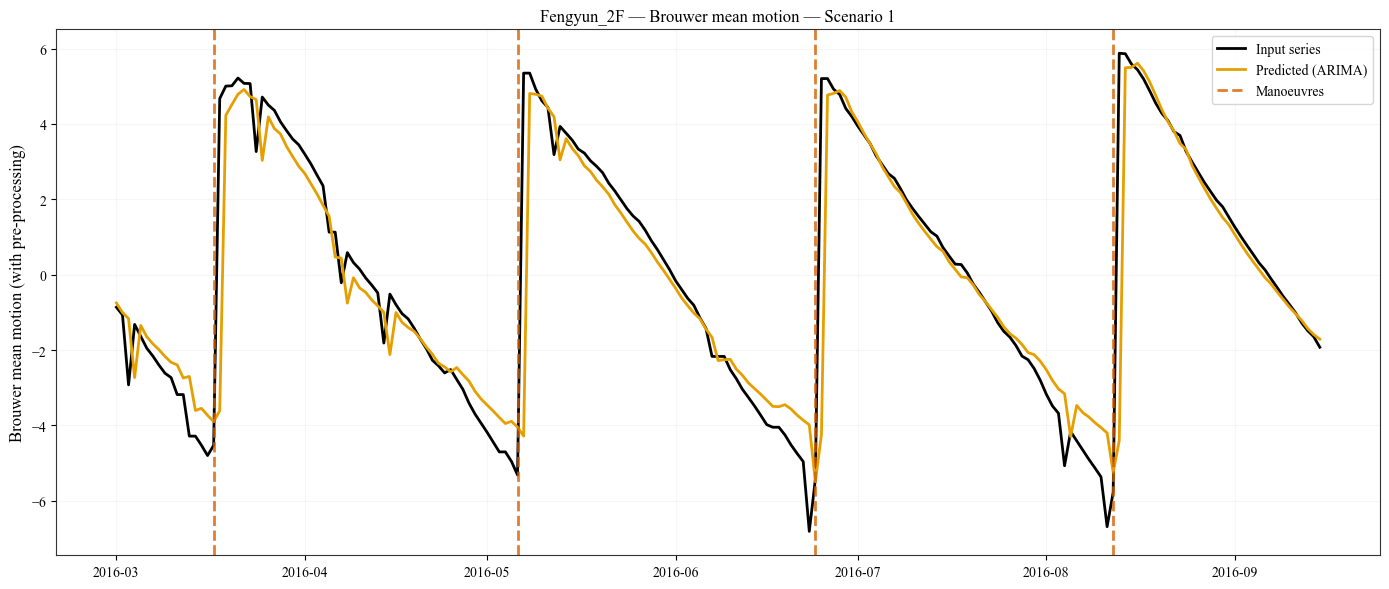

In [754]:
plot_predictions_standard(
    algorithm='arima',
    results=arima_prediction_results,
    maneuvers_dict=arima_ground_truth_dict,
    satellite='Fengyun_2F',
    variable='Brouwer mean motion',
    scenario='Scenario 1',
    start_date='2016-03-01',
    end_date='2016-09-15',
    save_as= "Section51_Figure1"
)

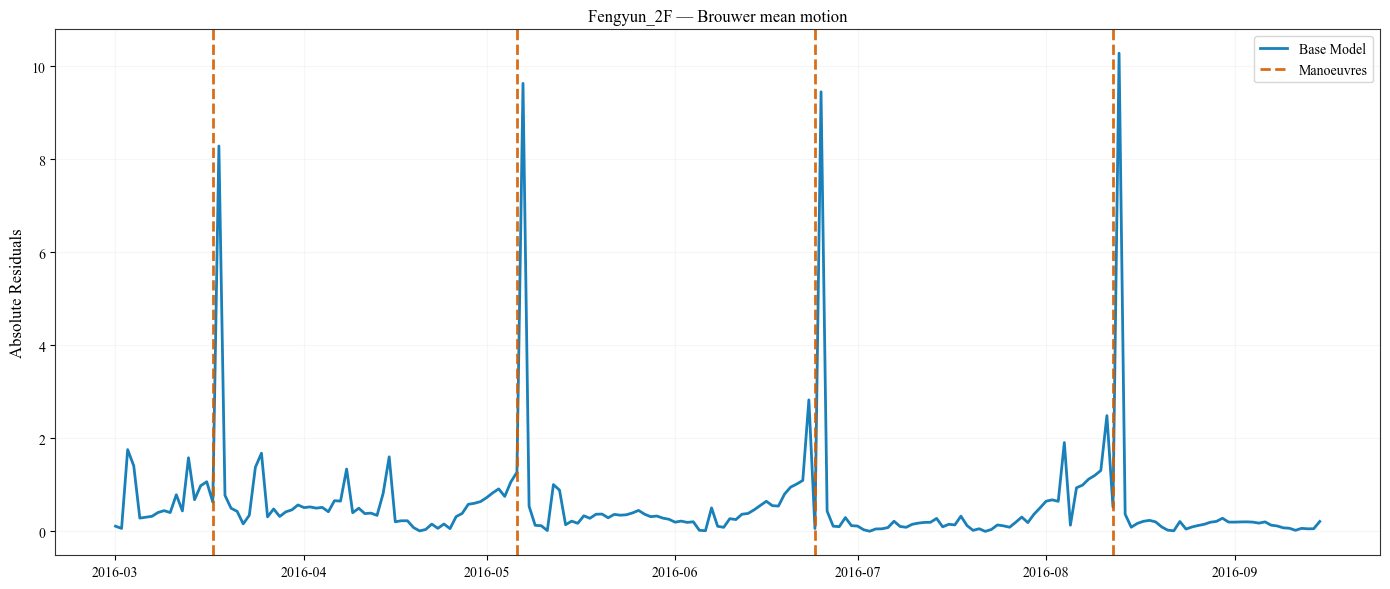

In [756]:
plot_residuals_with_maneuvers(
    results=arima_prediction_results,
    maneuvers_dict=arima_ground_truth_dict,
    satellite="Fengyun_2F",
    variable="Brouwer mean motion",
    scenarios=["Scenario 1"],
    algorithm="arima",
    start_date="2016-03-01",
    end_date="2016-09-15",
    plot_absolute=True,
    save_as= "Section51_Figure2"
)

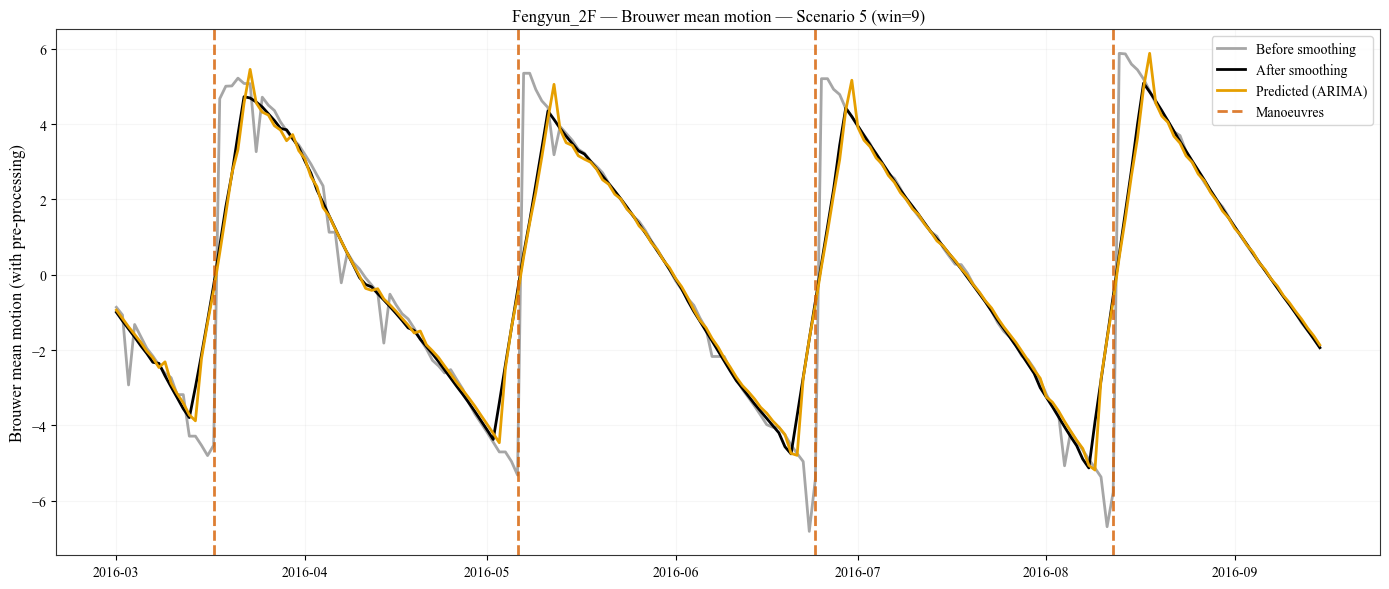

In [760]:
plot_predictions_scenario5(
    results=arima_prediction_results,
    maneuvers_dict=arima_ground_truth_dict,
    satellite='Fengyun_2F',
    variable='Brouwer mean motion',
    scenario='Scenario 5 (win=9)',
    start_date='2016-03-01',
    end_date='2016-09-15',
    save_as= "Section51_Figure3"
)

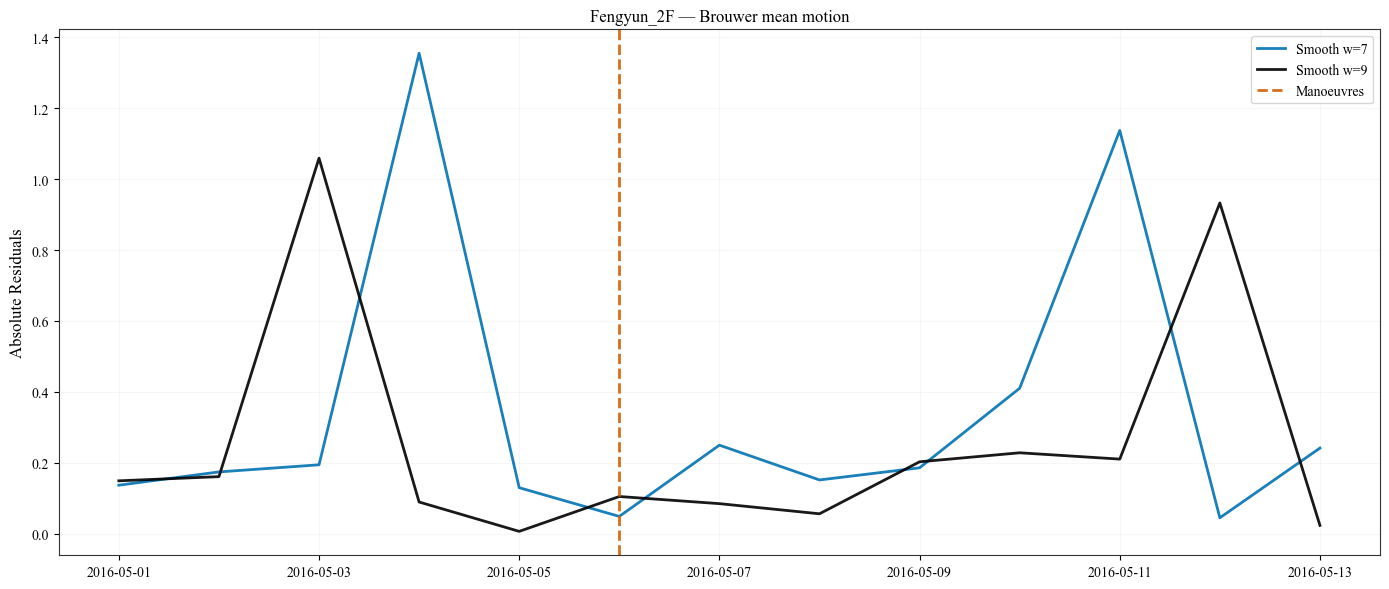

In [762]:
plot_residuals_with_maneuvers(
    results=arima_prediction_results,
    maneuvers_dict=arima_ground_truth_dict,
    satellite="Fengyun_2F",
    variable="Brouwer mean motion",
    scenarios=["Scenario 5 (win=7)", "Scenario 5 (win=9)"],
    algorithm="arima",
    start_date="2016-05-01",
    end_date="2016-05-13",
    plot_absolute=True,
    save_as="Section51_Figure4")

## Sensitivity of Detection Performance to Matching Window Size

In [831]:
#Group 2: ["Jason_3", "Fengyun_2E", "Sentinel_3B", "CryoSat_2"]
#Group 1:["Fengyun_2F", "Sentinel_3A"]

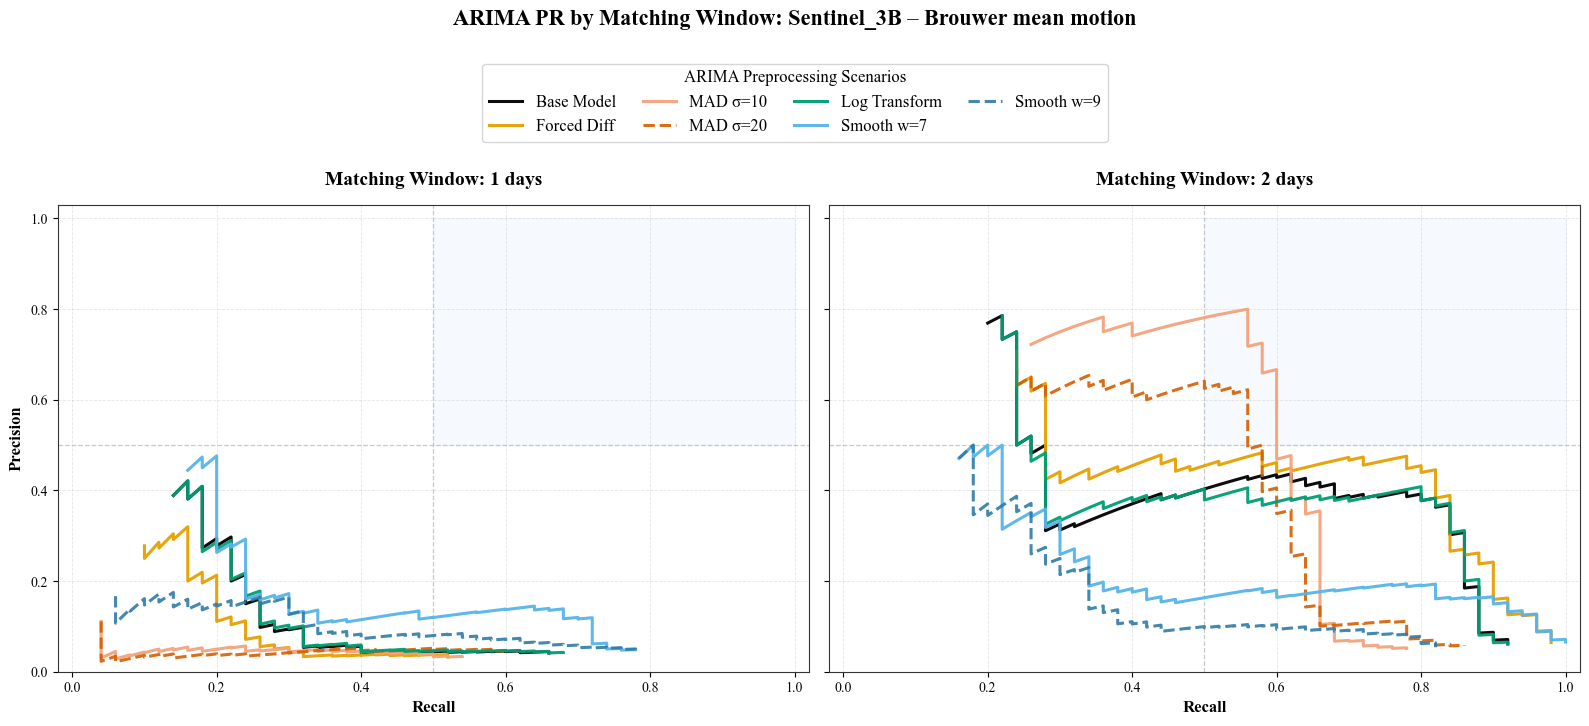

In [877]:
plot_precision_recall_comparison_by_window(
    pr_data_arima=arima_pr_data,
    satellite="Sentinel_3B",
    variable="Brouwer mean motion",
    match_days_pair=(1, 2),
    algorithm_name="ARIMA",
    save_path="Section52_Figure1.png"
)

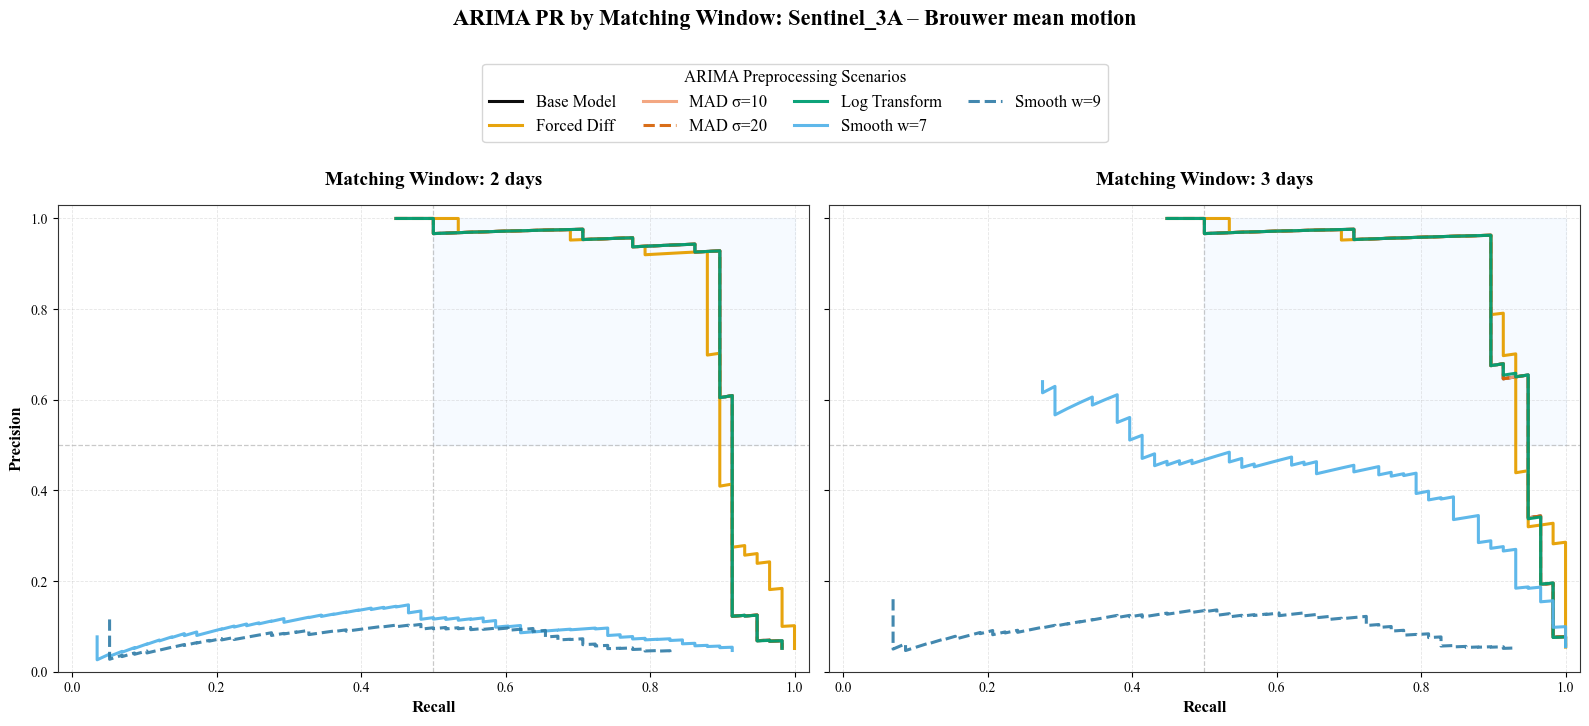

In [879]:
plot_precision_recall_comparison_by_window(
    pr_data_arima=arima_pr_data,
    satellite="Sentinel_3A",
    variable="Brouwer mean motion",
    match_days_pair=(2, 3),
    algorithm_name="ARIMA",
    save_path="Section52_Figure2.png"
)

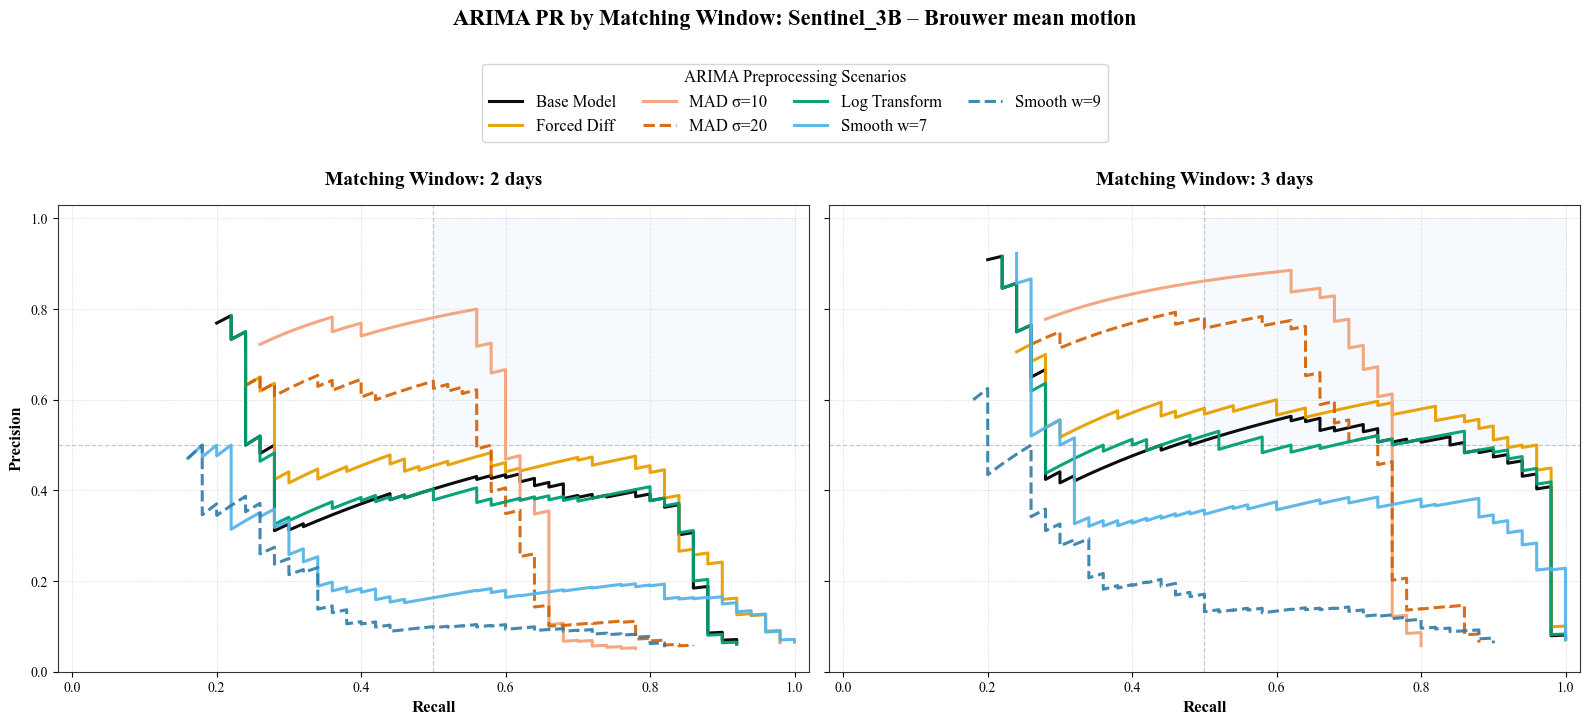

In [881]:
plot_precision_recall_comparison_by_window(
    pr_data_arima=arima_pr_data,
    satellite="Sentinel_3B",
    variable="Brouwer mean motion",
    match_days_pair=(2, 3),
    algorithm_name="ARIMA",
    save_path="Section52_Figure3.png"
)

## XGBoost Results

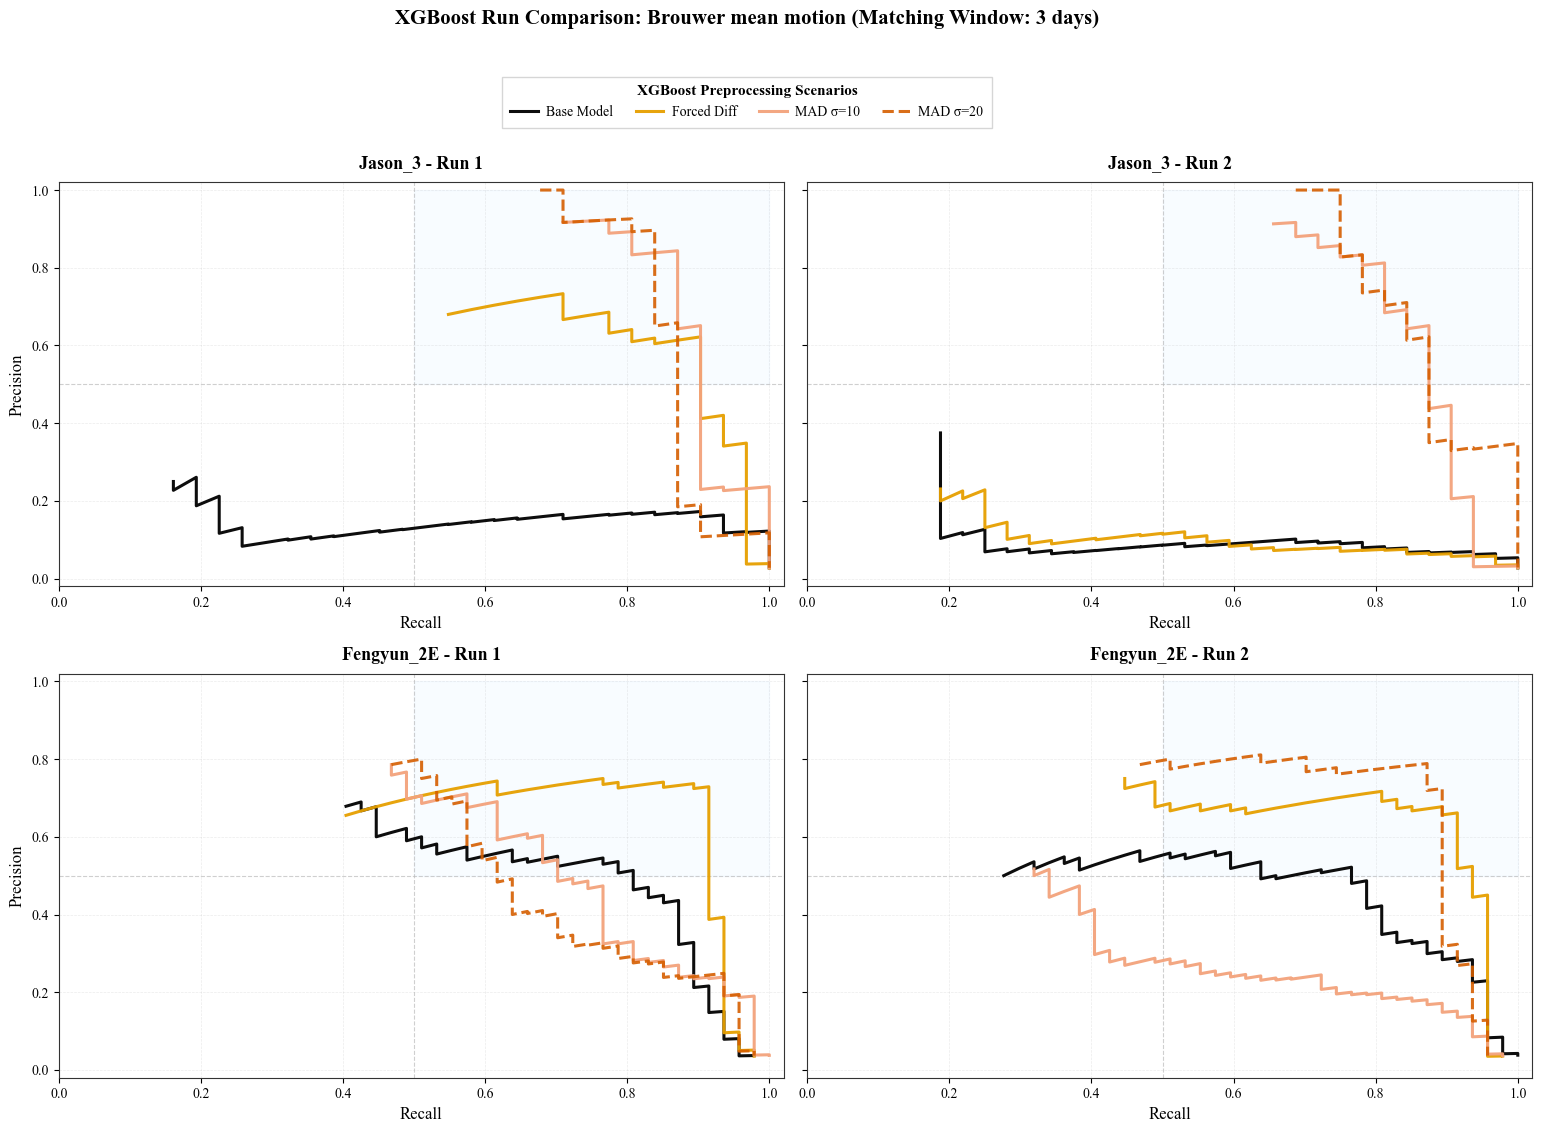

In [87]:
plot_xgboost_run_comparison(
    pr_data_run1=xgb_pr_data2,
    pr_data_run2=xgb_pr_data3,
    satellites=['Jason_3', 'Fengyun_2E'],
    variable='Brouwer mean motion',
    run1_label="Run 1",
    run2_label="Run 2",
    matching_days=3,
    figsize=(16, 12),  # Larger figure
    shade_operating_region=True,  # No shading
    save_path="Section552_Figure1.png"
)

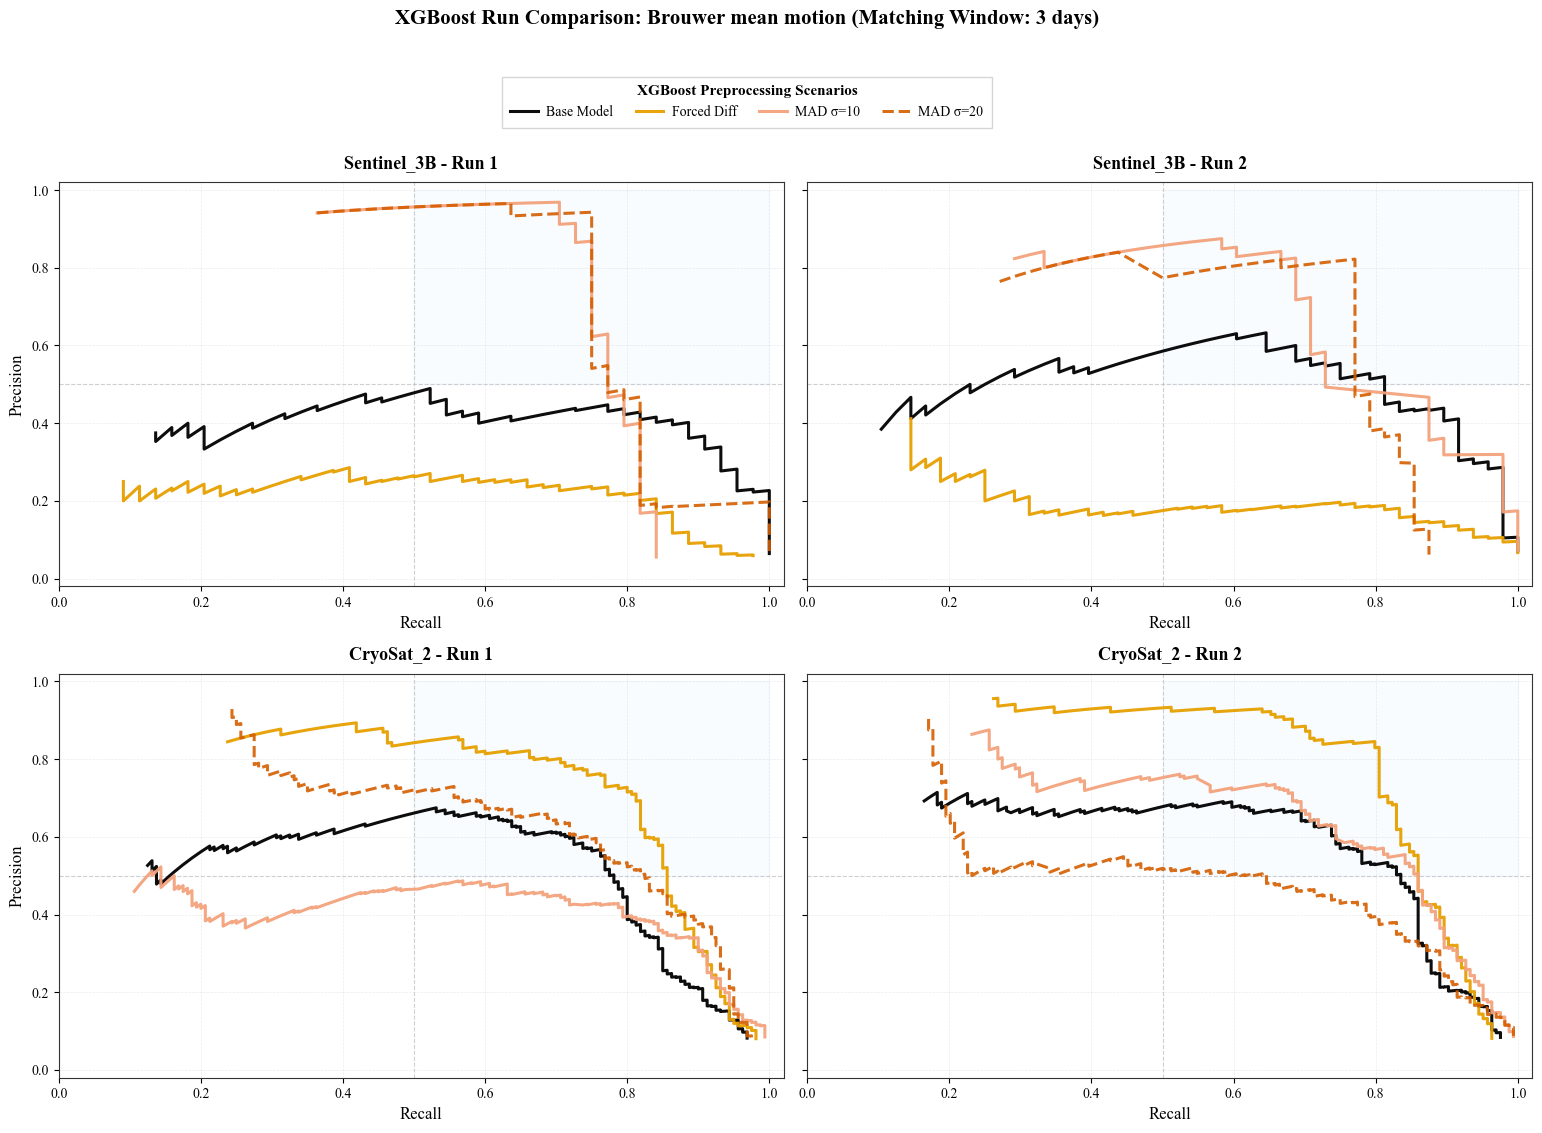

In [89]:
plot_xgboost_run_comparison(
    pr_data_run1=xgb_pr_data2,
    pr_data_run2=xgb_pr_data3,
    satellites=['Sentinel_3B', 'CryoSat_2'],
    variable='Brouwer mean motion',
    run1_label="Run 1",
    run2_label="Run 2",
    matching_days=3,
    figsize=(16, 12),  # Larger figure
    shade_operating_region=True,  
    save_path="Section552_Figure2.png"
)

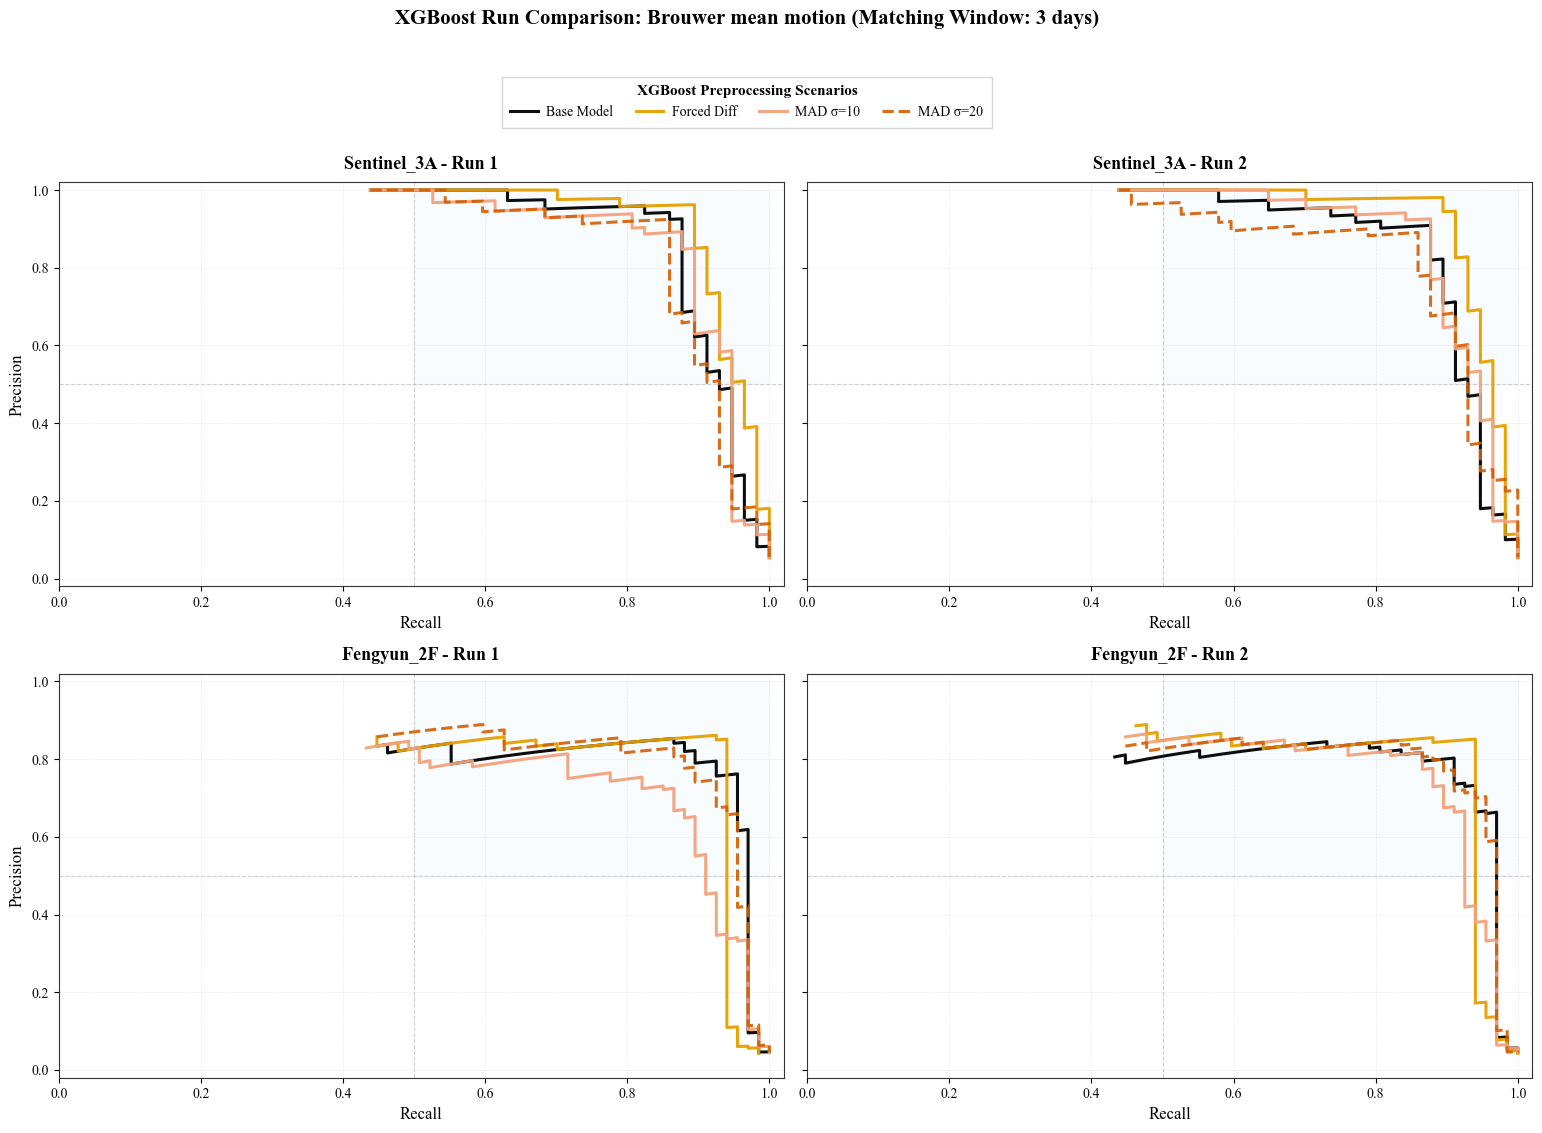

In [91]:
plot_xgboost_run_comparison(
    pr_data_run1=xgb_pr_data2,
    pr_data_run2=xgb_pr_data3,
    satellites=['Sentinel_3A', 'Fengyun_2F'],
    variable='Brouwer mean motion',
    run1_label="Run 1",
    run2_label="Run 2",
    matching_days=3,
    figsize=(16, 12),  # Larger figure
    shade_operating_region=True,  
    save_path="Section552_Figure3.png"
)

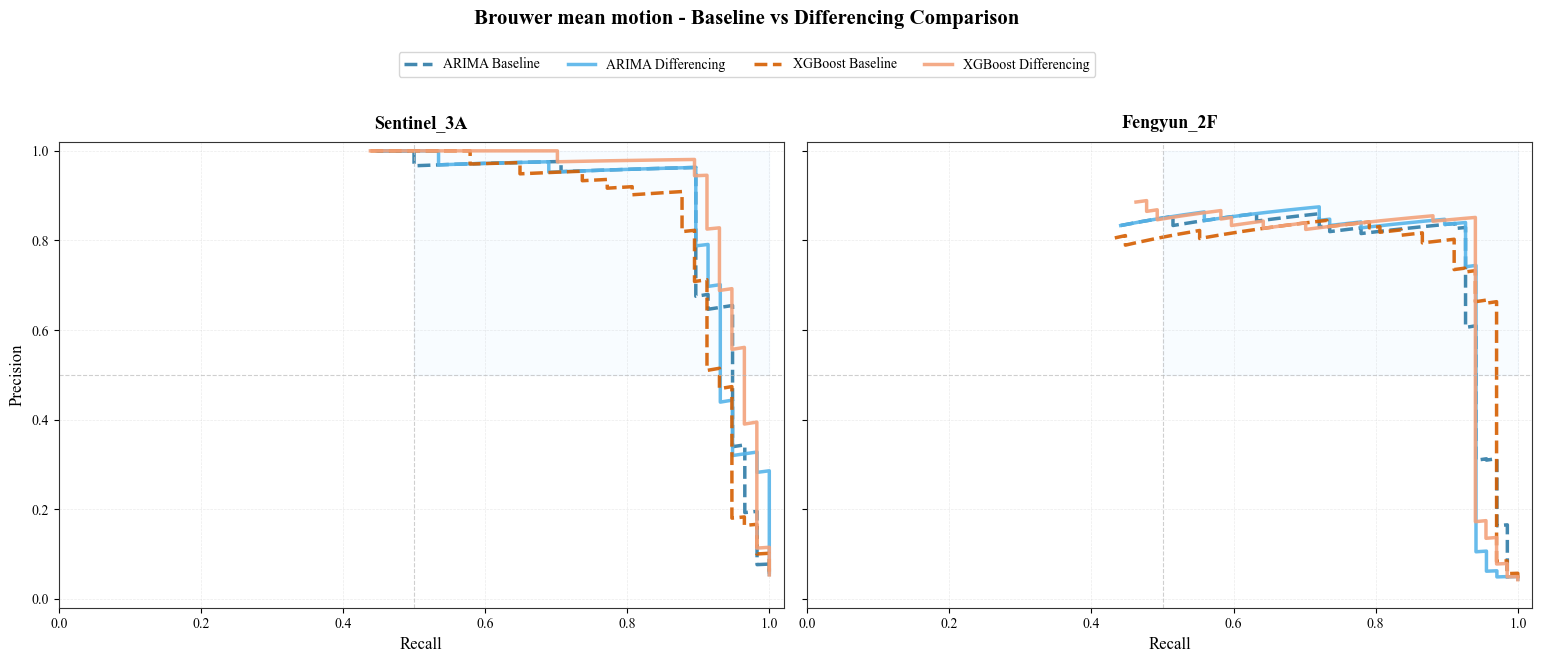

In [149]:
plot_baseline_vs_differencing_comparison(arima_pr_data, xgb_pr_data3, 
                                         ['Sentinel_3A', 'Fengyun_2F'],
                                         'Brouwer mean motion', save_path='Figure553_1.png')

# Evaluataion Framework Analysis

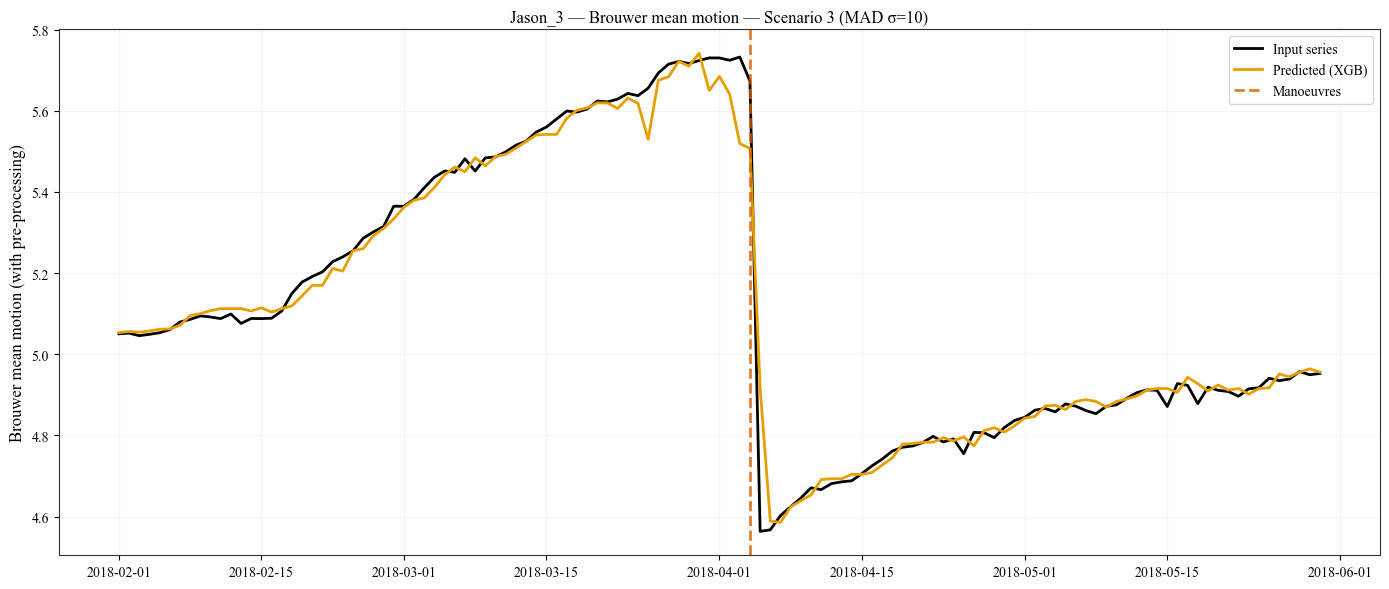

In [175]:
plot_predictions_standard(
    algorithm='xgb',
    results=xgb_prediction_results3,
    maneuvers_dict=arima_ground_truth_dict,
    satellite='Jason_3',
    variable='Brouwer mean motion',
    scenario='Scenario 3 (MAD σ=10)',
    start_date='2018-02-01',
    end_date='2018-05-30',
    save_as= "Section6_Figure1"
)

In [181]:
debug_info_arima = debug_evaluation_matching(
    retraining_results=xgb_prediction_results3, 
    ground_truth_dict=xgb_ground_truth_dict,  
    satellite='Jason_3', 
    variable='Brouwer mean motion',
    scenario='Scenario 3 (MAD σ=10)'
)

Threshold Analysis for Jason_3 - Brouwer mean motion - Scenario 3 (MAD σ=10):
Best F1: 0.8125 at threshold 0.206831 (P=0.8125, R=0.8125)
Best F2: 0.8187 at threshold 0.169693 (P=0.6512, R=0.8750)
100% Recall: at threshold 0.014491 (P=0.0325)


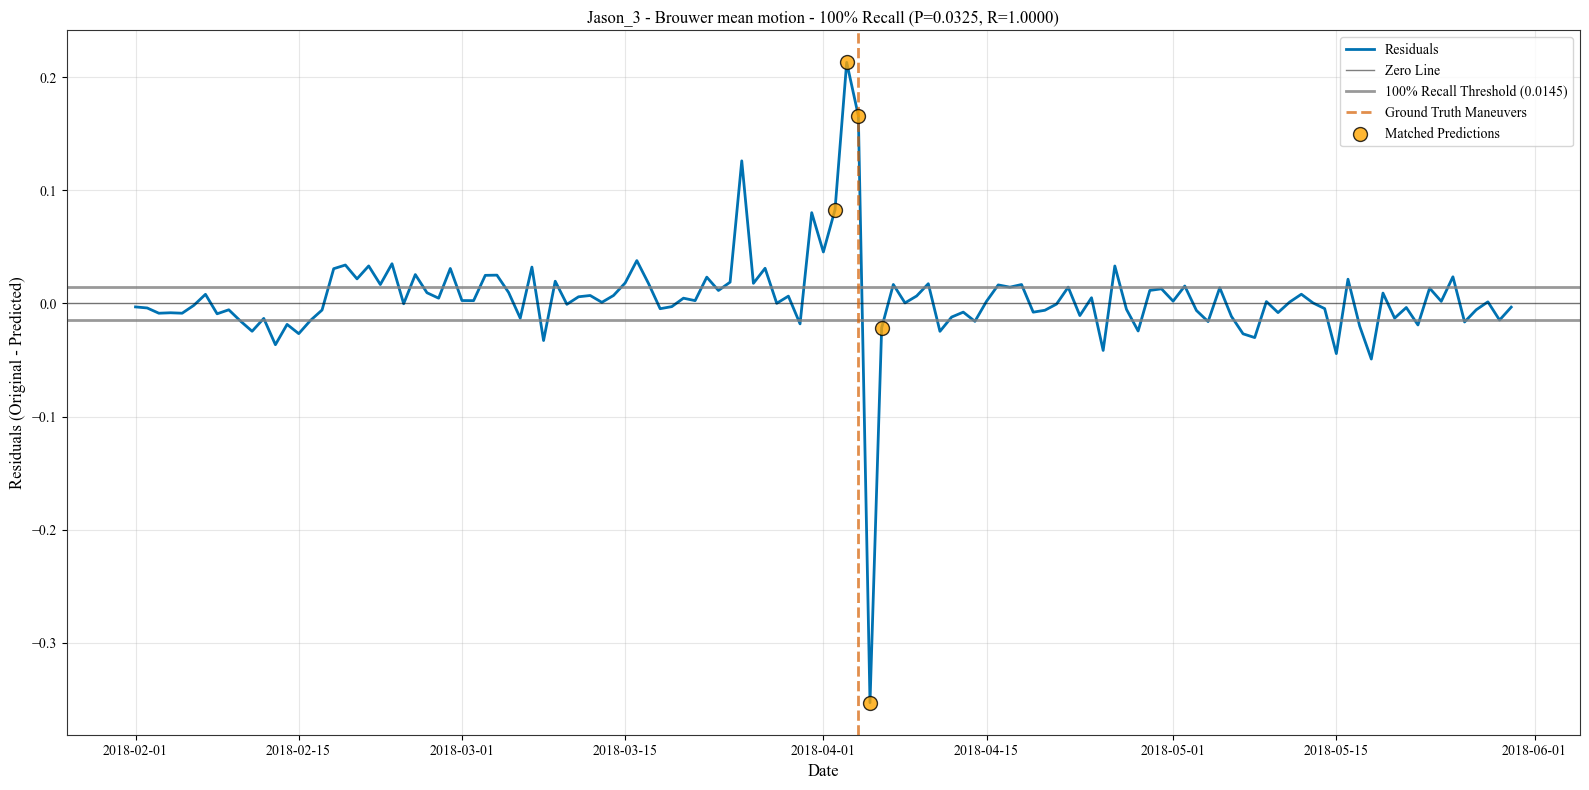


Matching Summary for 100% Recall:
Threshold: 0.014491
Precision: 0.0325, Recall: 1.0000
Total ground truth maneuvers: 32
Matched maneuvers: 32
Unmatched maneuvers (false negatives): 0
False positive predictions: 952

Detailed Matches:
  GT: 2016-02-23 00:00:00 -> Pred: 2016-02-21 00:00:00 (Δ=2.00 days, Value=0.0203)
  GT: 2016-02-23 00:00:00 -> Pred: 2016-02-22 00:00:00 (Δ=1.00 days, Value=0.0650)
  GT: 2016-02-23 00:00:00 -> Pred: 2016-02-24 00:00:00 (Δ=1.00 days, Value=0.1425)
  GT: 2016-02-23 00:00:00 -> Pred: 2016-02-25 00:00:00 (Δ=2.00 days, Value=0.2193)
  GT: 2016-04-04 00:00:00 -> Pred: 2016-04-02 00:00:00 (Δ=2.00 days, Value=0.1199)
  GT: 2016-04-04 00:00:00 -> Pred: 2016-04-03 00:00:00 (Δ=1.00 days, Value=0.0956)
  GT: 2016-04-04 00:00:00 -> Pred: 2016-04-04 00:00:00 (Δ=0.00 days, Value=0.0170)
  GT: 2016-04-04 00:00:00 -> Pred: 2016-04-05 00:00:00 (Δ=1.00 days, Value=0.2407)
  GT: 2016-04-04 00:00:00 -> Pred: 2016-04-06 00:00:00 (Δ=2.00 days, Value=0.3692)
  GT: 2016-05-19 

In [185]:
plot_debug_residuals_with_matching(debug_info_arima, 
                                   threshold_type='recall_100', 
                                   satellite='Jason_3', 
                                   start_date='2018-02-01',
                                   end_date='2018-05-30')

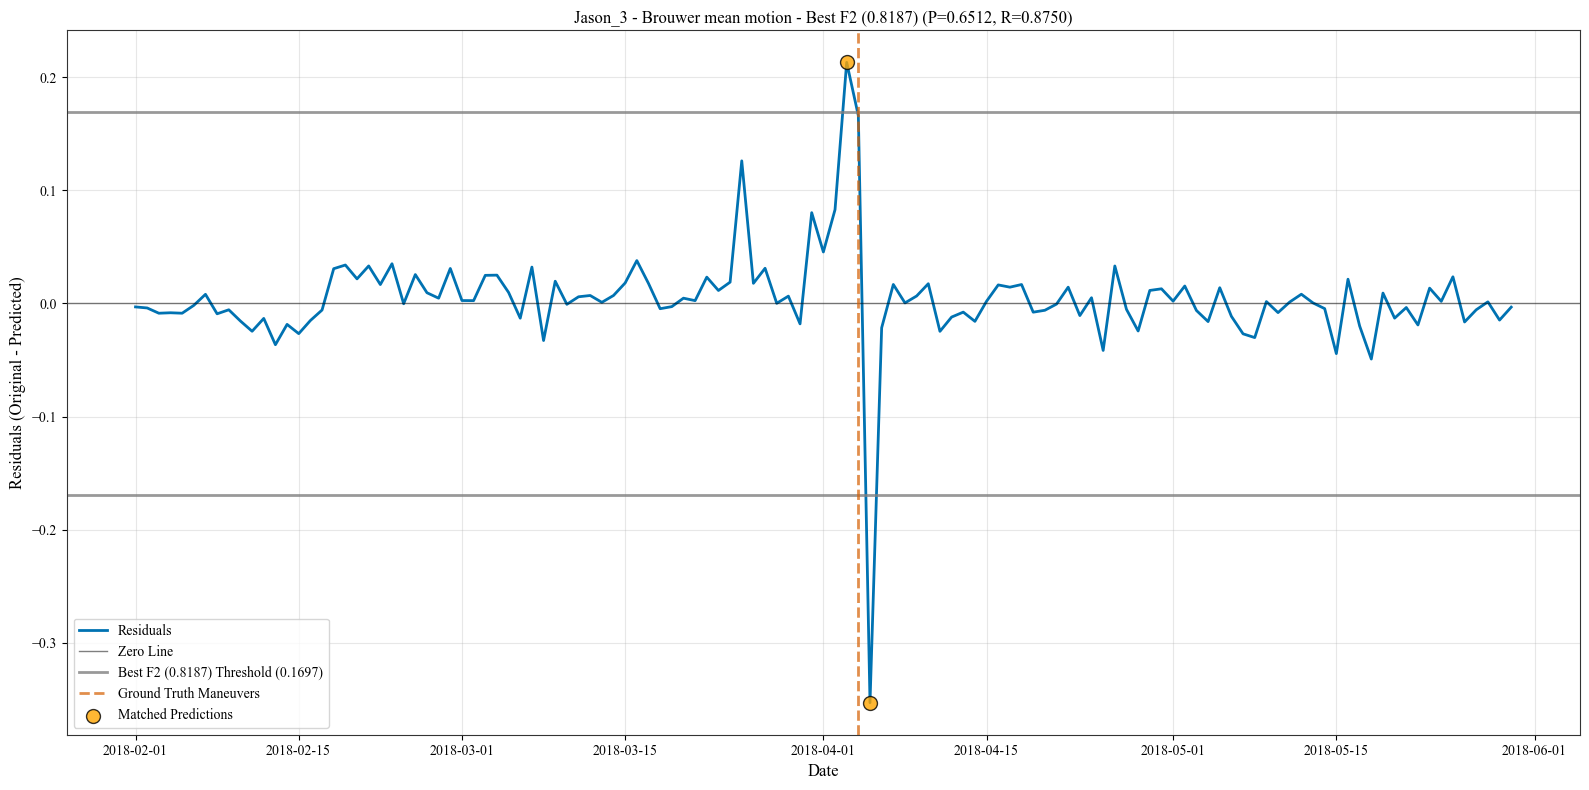


Matching Summary for Best F2 (0.8187):
Threshold: 0.169693
Precision: 0.6512, Recall: 0.8750
Total ground truth maneuvers: 32
Matched maneuvers: 28
Unmatched maneuvers (false negatives): 4
False positive predictions: 15

Detailed Matches:
  GT: 2016-02-23 00:00:00 -> Pred: 2016-02-25 00:00:00 (Δ=2.00 days, Value=0.2193)
  GT: 2016-04-04 00:00:00 -> Pred: 2016-04-05 00:00:00 (Δ=1.00 days, Value=0.2407)
  GT: 2016-04-04 00:00:00 -> Pred: 2016-04-06 00:00:00 (Δ=2.00 days, Value=0.3692)
  GT: 2016-05-19 00:00:00 -> Pred: 2016-05-21 00:00:00 (Δ=2.00 days, Value=0.1771)
  GT: 2016-07-25 00:00:00 -> Pred: 2016-07-26 00:00:00 (Δ=1.00 days, Value=0.2144)
  GT: 2016-09-14 00:00:00 -> Pred: 2016-09-12 00:00:00 (Δ=2.00 days, Value=0.2236)
  GT: 2016-09-14 00:00:00 -> Pred: 2016-09-15 00:00:00 (Δ=1.00 days, Value=0.4183)
  GT: 2016-12-22 00:00:00 -> Pred: 2016-12-23 00:00:00 (Δ=1.00 days, Value=0.6626)
  GT: 2017-04-12 00:00:00 -> Pred: 2017-04-13 00:00:00 (Δ=1.00 days, Value=0.5536)
  GT: 2017-09

In [187]:
plot_debug_residuals_with_matching(debug_info_arima, 
                                   threshold_type='best_f2', 
                                   satellite='Jason_3', 
                                   start_date='2018-02-01',
                                   end_date='2018-05-30')